In [1]:
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from itertools import combinations
from collections import defaultdict

In [2]:
data_fp = '/Users/JakeCanfield/Documents/Trauma_Surgery_Research/Data/Raw_data/PUF AY %i/CSV/'
years = range(2017, 2023)
thoracotomy_codes = ['0WJB0ZZ', '0WJ90ZZ', '02JA0ZZ', '02JY0ZZ', '0BJL0ZZ', '0BJK0ZZ', '0BJQ0ZZ','0WJ80ZZ', '0WJC0ZZ', '0WJD0ZZ', '02VW0CZ', '02QA0ZZ', '3E080GC']
sternotomy_codes = ['0P800ZZ']

mechanism_code_dict = {1:'Cut/pierce', 2:'Drowning/submersion', 3:'Fall', 4:'Fire/flame', 5:'Hot object/substance', 6:'Firearm', 7:'Machinery', 8:'MVT Occupant', 9:'MVT Motorcyclist', 10:'MVT Pedal cyclist', 11:'MVT Pedestrian', 12:'MVT Unspecified', 13:'MVT Other', 14:'Pedal cyclist, other', 15:'Pedestrian, other', 16:'Transport, other', 17:'Natural/environmental,  Bites and stings', 18:'Natural/environmental,  Other', 19:'Overexertion', 20:'Poisoning', 21:'Struck by, against', 22:'Suffocation', 23:'Other specified and classifiable', 24:'Other specified, not elsewhere classifiable', 25:'Unspecified', 26:'Adverse effects, medical care', 27:'Adverse effects, drugs'} # As noted in PUF dictionary
trauma_type_code_dict = {1:'Blunt', 2:'Penetrating', 3:'Burn', 4:'Other/unspecified', 9:'Activity Code - Not Valid as a Primary E-Code'} # As noted in PUF Dictionary
sex_code_dict = {1:'Male', 2:'Female'}
eddischarge_code_dict = {1: 'Floor bed (general admission, non-specialty unit bed)', 2: 'Observation unit (unit that provides < 24 hour stays)', 3: 'Telemetry/step-down unit (less acuity than ICU)', 4: 'Home with services', 5: 'Deceased/expired', 6: 'Other (jail, institutional care, mental health, etc.)', 7: 'Operating Room', 8: 'Intensive Care Unit (ICU)', 9: 'Home without services', 10: 'Left against medical advice', 11: 'Transferred to another hospital'}
hospdischarge_disposition_code_dict = {1: 'Discharged/Transferred to a short-term general hospital for inpatient care', 2: 'Discharged/Transferred to an Intermediate Care Facility (ICF)', 3: 'Discharged/Transferred to home under care of organized home health service', 4: 'Left against medical advice or discontinued care', 5: 'Deceased/Expired', 6: 'Discharged to home or self-care (routine discharge)', 7: 'Discharged/Transferred to Skilled Nursing Facility (SNF)', 8: 'Discharged/Transferred to hospice care', 10: 'Discharged/Transferred to court/law enforcement', 11: 'Discharged/Transferred to inpatient rehab or designated unit', 12: 'Discharged/Transferred to Long Term Care Hospital (LTCH)', 13: 'Discharged/Transferred to a psychiatric hospital or psychiatric distinct part unit of a hospital', 14: 'Discharged/Transferred to another type of institution not defined elsewhere'}

cols17 = pd.read_csv(data_fp%(2017)+'PUF_TRAUMA.csv', nrows=1).columns.tolist()
cols19 = pd.read_csv(data_fp%(2017)+'PUF_TRAUMA.csv', nrows=1).columns.tolist()
cols17 = [x.upper() for x in cols17]
cols19 = [x.upper() for x in cols19]

common_cols = list(set(cols17) & set(cols19))
display(np.shape(common_cols))

(330,)

# Data Exploration of Thoracotomy Data Population

## Combine years of data into one `DataFrame` for figure generation

In [ ]:
for year in years:
    
    if year in range(2017, 2019):
        TRAUMA_df = pd.read_csv(data_fp%year + 'PUF_TRAUMA.csv')
        ICDPROCEDURE_df = pd.read_csv(data_fp%year + 'PUF_ICDPROCEDURE.csv')
        ICDPROCEDURE_LOOKUP_df = pd.read_csv(data_fp%year + 'PUF_ICDPROCEDURE_LOOKUP.csv')
        ECODE_LOOKUP_df = pd.read_csv(data_fp%year + 'PUF_ECODE_LOOKUP.csv')
    elif year in range(2019, 2023):
        TRAUMA_df = pd.read_csv(data_fp%year + 'PUF_TRAUMA.csv')
        ICDPROCEDURE_df = pd.read_csv(data_fp%year + 'PUF_ICDPROCEDURE.csv')
        ICDPROCEDURE_LOOKUP_df = pd.read_csv(data_fp%year + 'PUF_ICDPROCEDURE_LOOKUP.csv')
        ECODE_LOOKUP_df = pd.read_csv(data_fp%year + 'PUF_ECODE_LOOKUP.csv')
    
    TRAUMA_df.columns = map(str.upper, TRAUMA_df.columns)
    ICDPROCEDURE_df.columns = map(str.upper, ICDPROCEDURE_df.columns)
    ICDPROCEDURE_LOOKUP_df.columns = map(str.upper, ICDPROCEDURE_LOOKUP_df.columns)
    ECODE_LOOKUP_df.columns = map(str.upper, ECODE_LOOKUP_df.columns)
    
    ECODE_LOOKUP_df = ECODE_LOOKUP_df.loc[:, ['ECODE', 'ECODE_DESC', 'MECHANISM', 'TRAUMATYPE']]
    
    trauma_cols = np.unique(['INC_KEY', 'PRIMARYECODEICD10', 'AGEYEARS', 'SEX', 'EDDISCHARGEDISPOSITION', 'HOSPDISCHARGEDISPOSITION'] + common_cols)
    TRAUMA_df = TRAUMA_df.loc[:, trauma_cols]
    TRAUMA_df = TRAUMA_df.loc[TRAUMA_df['HMRRHGCTRLSURGTYPE'] == 3.0]
    
    procedure_dict = dict(zip(ICDPROCEDURE_LOOKUP_df['ICDPROCEDURECODE'], ICDPROCEDURE_LOOKUP_df['ICDPROCEDURECODE_DESC'])) # create dictionary
    ICDPROCEDURE_df['ICDPROCEDURECODE'] = ICDPROCEDURE_df['ICDPROCEDURECODE'].replace(procedure_dict) # implement dictionary
    
    ecode_dict = dict(zip(ECODE_LOOKUP_df['ECODE'], ECODE_LOOKUP_df['ECODE_DESC'])) # create dictionary
    TRAUMA_df['PRIMARYECODEICD10'] = TRAUMA_df['PRIMARYECODEICD10'].replace(ecode_dict) # implement dictionary
    
    mechanism_dict = dict(zip(ECODE_LOOKUP_df['ECODE_DESC'], ECODE_LOOKUP_df['MECHANISM'])) # create dictionary
    TRAUMA_df['MECHANISM'] = TRAUMA_df['PRIMARYECODEICD10'].map(mechanism_dict) # implement dictionary
    
    traumatype_dict = dict(zip(ECODE_LOOKUP_df['ECODE_DESC'], ECODE_LOOKUP_df['TRAUMATYPE'])) # create dictionary
    TRAUMA_df['TRAUMATYPE'] = TRAUMA_df['PRIMARYECODEICD10'].map(traumatype_dict) # implement dictionary
    
    TRAUMA_df['MECHANISM'] = TRAUMA_df['MECHANISM'].replace(mechanism_code_dict) # implement dictionary
    
    TRAUMA_df['TRAUMATYPE'] = TRAUMA_df['TRAUMATYPE'].replace(trauma_type_code_dict) # implement dictionary
    
    TRAUMA_df['SEX'] = TRAUMA_df['SEX'].replace(sex_code_dict)
    
    TRAUMA_df['EDDISCHARGEDISPOSITION'] = TRAUMA_df['EDDISCHARGEDISPOSITION'].replace(eddischarge_code_dict) # implement dictionary
    
    TRAUMA_df['HOSPDISCHARGEDISPOSITION'] = TRAUMA_df['HOSPDISCHARGEDISPOSITION'].replace(hospdischarge_disposition_code_dict) # implement dictionary
    
    TRAUMA_df = TRAUMA_df.loc[TRAUMA_df['TRAUMATYPE'].isin(['Blunt', 'Penetrating'])]
    
    TRAUMA_df.to_csv('/Users/JakeCanfield/Documents/Trauma_Surgery_Research/data/Combined_data/newTRAUMA_df_%i.csv'%year, index=False)
    ICDPROCEDURE_df.to_csv('/Users/JakeCanfield/Documents/Trauma_Surgery_Research/data/Combined_data/newICDPROCEDURE_df_%i.csv'%year, index=False)
    
    display(ICDPROCEDURE_df.head())
    display(TRAUMA_df.head())

# Age Demographics

In [12]:
years = range(2017, 2023)
TRAUMA_fp = '/Users/JakeCanfield/Documents/Trauma_Surgery_Research/data/Combined_data/newTRAUMA_df_%i.csv'
ICDPROCEDURE_fp = '/Users/JakeCanfield/Documents/Trauma_Surgery_Research/data/Combined_data/newICDPROCEDURE_df_%i.csv'
TRAUMA_cols = pd.read_csv(TRAUMA_fp%2017, nrows=1).columns.tolist().append('Year')
ICDPROCEDURE_cols = pd.read_csv(ICDPROCEDURE_fp%2017, nrows=1).columns.tolist().append('Year')

TRAUMA_all_df = pd.DataFrame(columns=TRAUMA_cols)
ICDPROCEDURE_all_df = pd.DataFrame(columns=ICDPROCEDURE_cols)

for year in years:
    trauma_df = pd.read_csv(TRAUMA_fp%year)
    trauma_df['Year'] = year
    icdprocedure_df = pd.read_csv(ICDPROCEDURE_fp%year)
    icdprocedure_df['Year'] = year
    TRAUMA_all_df = pd.concat([TRAUMA_all_df, trauma_df], ignore_index=True)
    ICDPROCEDURE_all_df = pd.concat([ICDPROCEDURE_all_df, icdprocedure_df], ignore_index=True)

TRAUMA_all_df['HOSPDISCHARGEDISPOSITION'] = TRAUMA_all_df['HOSPDISCHARGEDISPOSITION'].fillna('Unknown')
TRAUMA_all_df['EDDISCHARGEDISPOSITION'] = TRAUMA_all_df['EDDISCHARGEDISPOSITION'].fillna('Unknown')
TRAUMA_all_df['SEX'] = TRAUMA_all_df['SEX'].replace('3.0', 'Unknown')

display(TRAUMA_all_df.head())
print(np.shape(TRAUMA_all_df))
display(ICDPROCEDURE_all_df.head())
print(np.shape(ICDPROCEDURE_all_df))

/Users/JakeCanfield/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  app.launch_new_instance()


ABUSEINVESTIGATION  ABUSEINVESTIGATION_BIU  ABUSEREPORT  ABUSEREPORT_BIU  \
0                 NaN                     1.0          2.0              NaN   
1                 NaN                     1.0          2.0              NaN   
2                 NaN                     1.0          2.0              NaN   
3                 NaN                     1.0          2.0              NaN   
4                 NaN                     1.0          2.0              NaN   

  ADDITIONALECODEICD10  ADDITIONALECODEICD10_BIU  AGEYEARS  \
0                  NaN                       1.0      33.0   
1                  NaN                       1.0      24.0   
2                  NaN                       1.0      31.0   
3             W74.XXXA                       NaN      24.0   
4                  NaN                       1.0      24.0   

   AIRBAG_DEPLOYED_FRNT  AIRBAG_DEPLOYED_NA  AIRBAG_DEPLOYED_OTHER  ...  \
0                     0                   0                      0  ...   
1                     0                   1                      0  ...   
2                     0                   1                      0  ...   
3                     0                   1                      0  ...   
4                     0                   1                      0  ...   

   WITHDRAWALLST  WITHDRAWALLSTDAYS  WITHDRAWALLSTMINS  WITHDRAWALLST_BIU  \
0            2.0                NaN                NaN                NaN   
1            2.0                NaN                NaN                NaN   
2            2.0                NaN                NaN                NaN   
3            NaN                NaN                NaN                2.0   
4            2.0                NaN                NaN                NaN   

   WORKRELATED  WORKRELATED_BIU  YODISCH   MECHANISM   TRAUMATYPE  Year  
0          2.0              NaN   2017.0     Firearm  Penetrating  2017  
1          2.0              NaN   2017.0  Cut/pierce  Penetrating  2017  
2          2.0              NaN   2017.0     Firearm  Penetrating  2017  
3          2.0              NaN   2017.0     Firearm  Penetrating  2017  
4          2.0              NaN   2017.0     Firearm  Penetrating  2017  

[5 rows x 333 columns]

(17442, 333)


HOSPITALPROCEDURESTARTDAYS  HOSPITALPROCEDURESTARTDH_BIU  \
0                         NaN                           NaN   
1                         NaN                           NaN   
2                         NaN                           NaN   
3                         NaN                           NaN   
4                         NaN                           NaN   

   HOSPITALPROCEDURESTARTHRS ICDPROCEDURECODE  ICDPROCEDURECODE_BIU  \
0                        NaN          BR20ZZZ                   NaN   
1                        NaN          BN25ZZZ                   NaN   
2                        NaN          2W3DX1Z                   NaN   
3                        NaN          B020ZZZ                   NaN   
4                        NaN          0T9B70Z                   NaN   

  ICDPROCEDUREVERSION       INC_KEY  PROCEDUREDAYS  PROCEDUREMINS  Year  
0               ICD10  170022785514            1.0           59.0  2017  
1               ICD10  170022785514            1.0           59.0  2017  
2               ICD10  170022785514            NaN            NaN  2017  
3               ICD10  170022785531            1.0           64.0  2017  
4               ICD10  170022785531            1.0           37.0  2017

(45181051, 10)


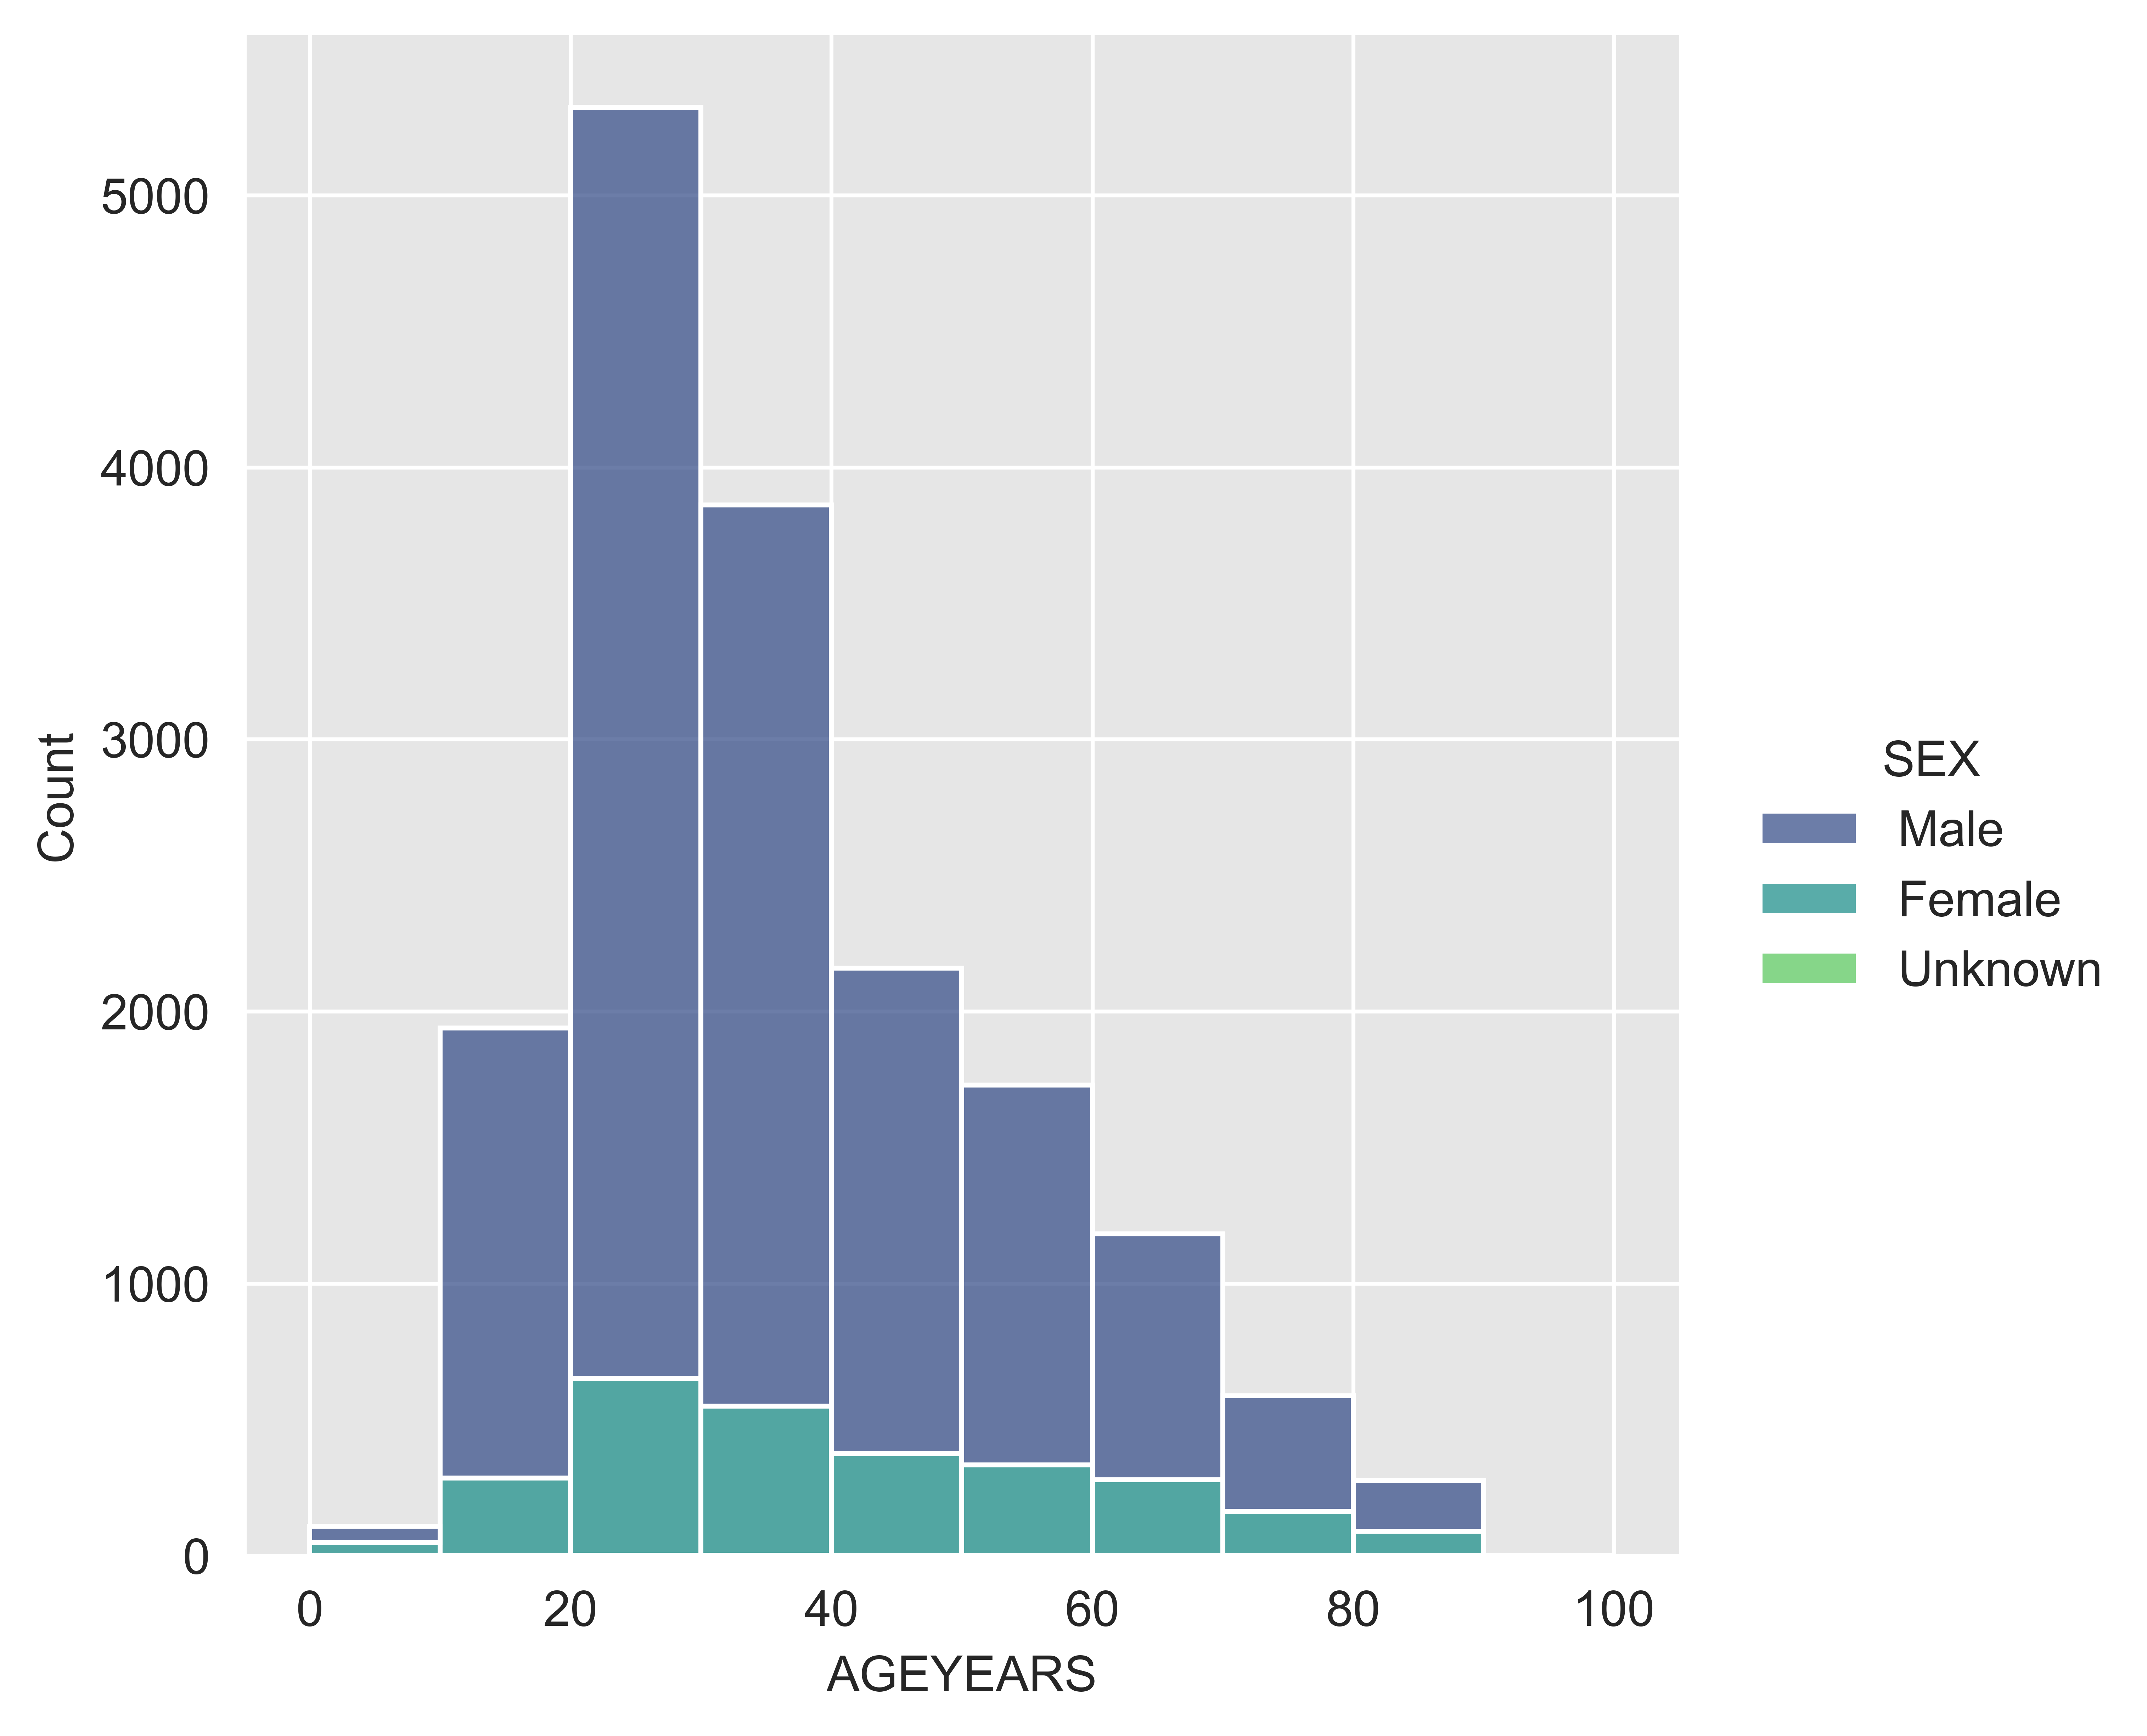

In [13]:
mpl.rcParams['figure.dpi'] = 1000
sns.set_style('darkgrid', {"axes.facecolor": ".9"})
sns.color_palette("viridis", as_cmap=True)

g = sns.displot(data=TRAUMA_all_df,
               x='AGEYEARS',
               hue='SEX',
               stat='count',
               binwidth=10,
               binrange=(0,100),
               palette='viridis',
               multiple='stack')
plt.show()

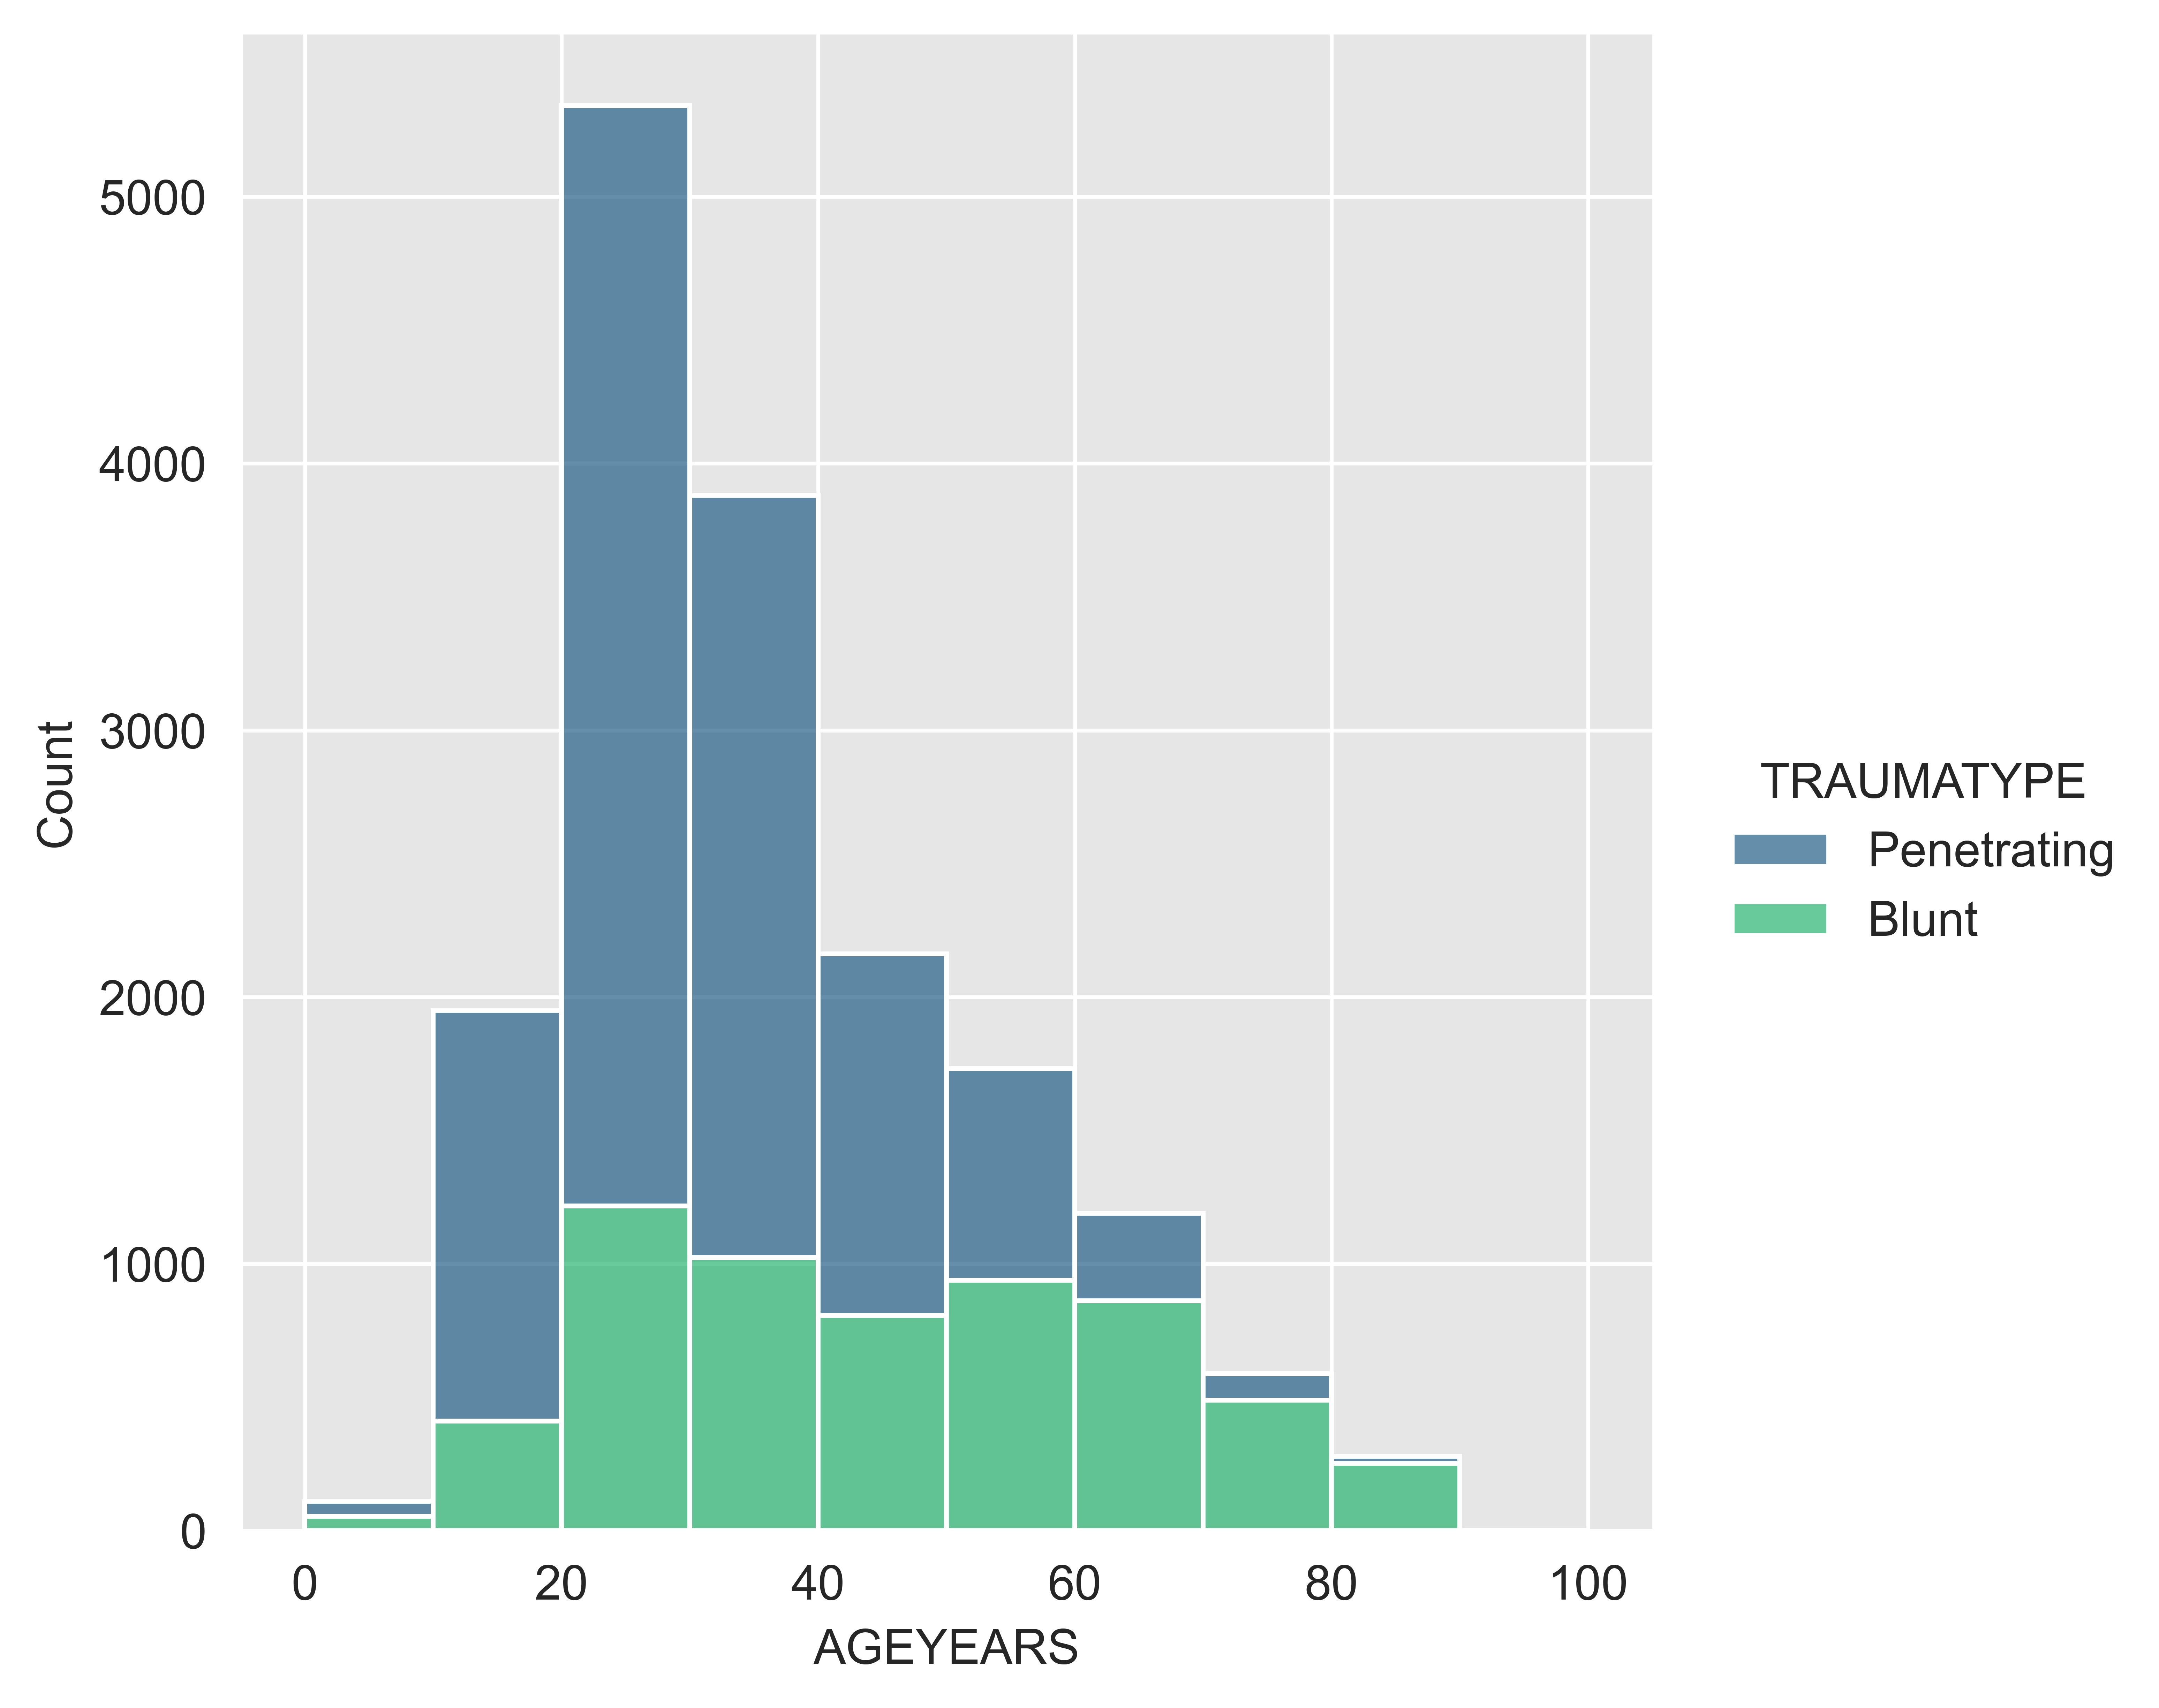

In [14]:
mpl.rcParams['figure.dpi'] = 1000
sns.set_style('darkgrid', {"axes.facecolor": ".9"})
sns.color_palette("viridis", as_cmap=True)

g = sns.displot(data=TRAUMA_all_df,
               x='AGEYEARS',
               hue='TRAUMATYPE',
               stat='count',
               binwidth=10,
               binrange=(0,100),
               palette='viridis',
               multiple='stack')
plt.show()

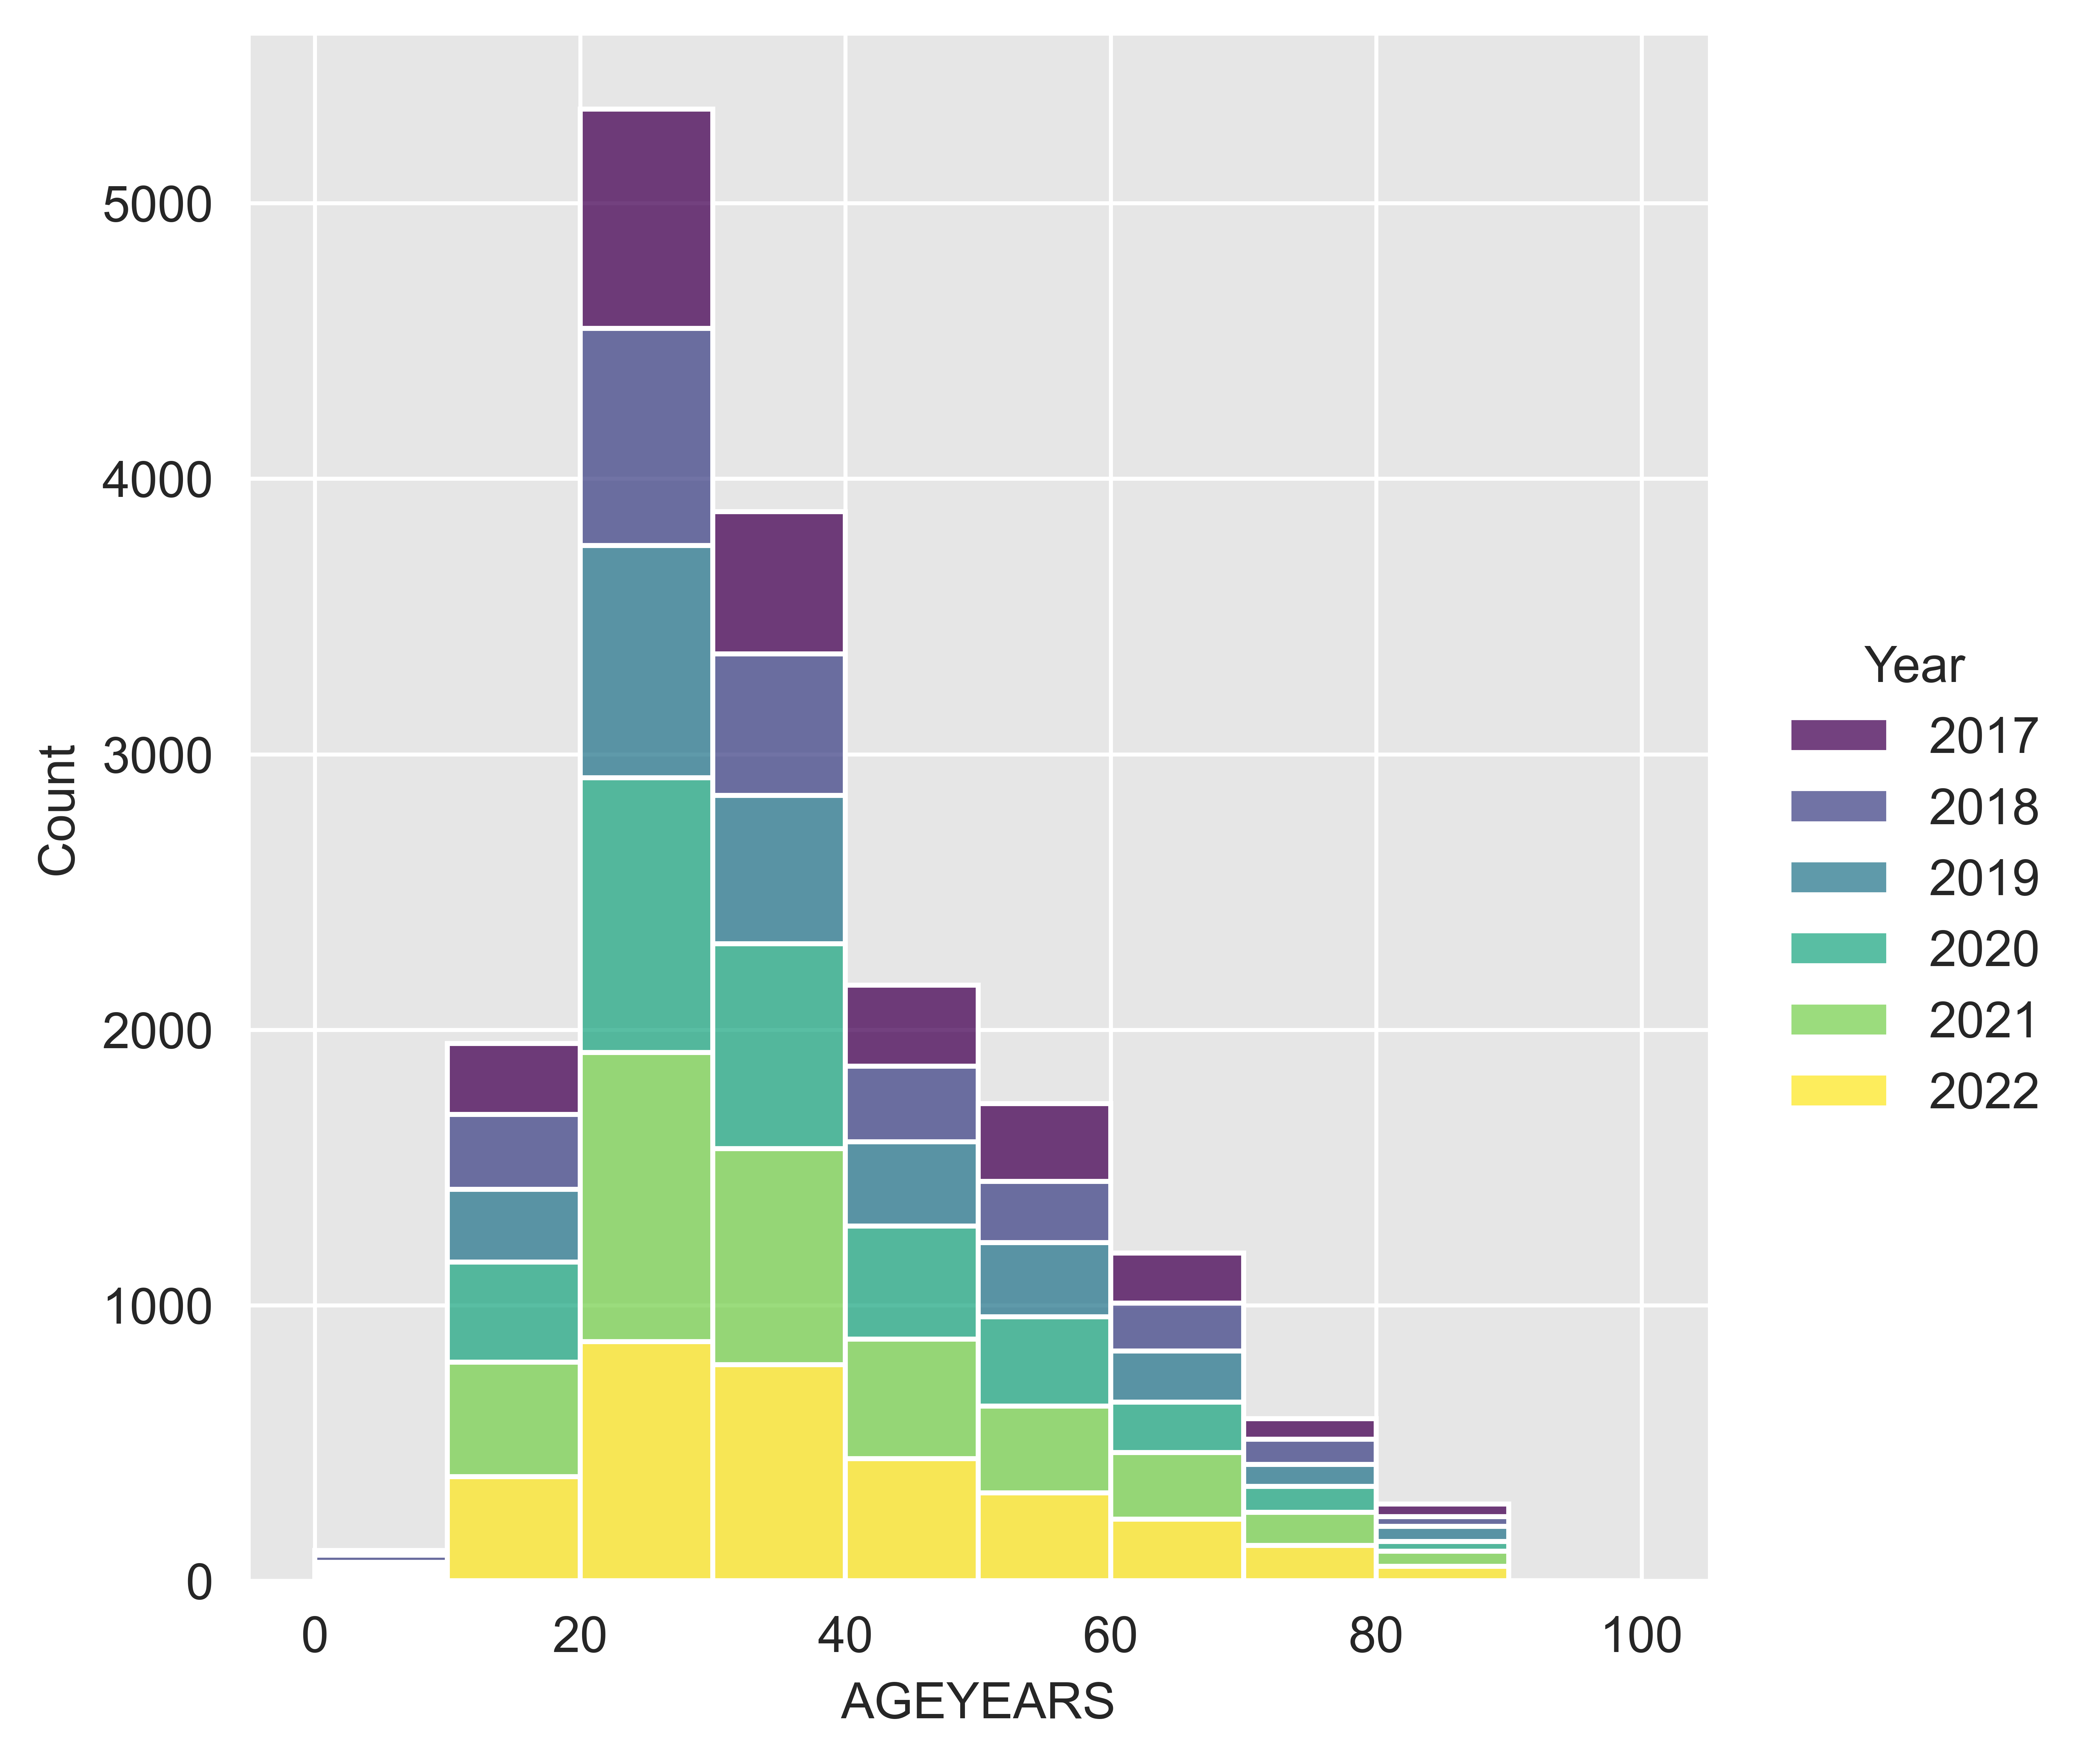

In [15]:
mpl.rcParams['figure.dpi'] = 1000
sns.set_style('darkgrid', {"axes.facecolor": ".9"})
sns.color_palette("viridis", as_cmap=True)

g = sns.displot(data=TRAUMA_all_df,
               x='AGEYEARS',
               hue='Year',
               stat='count',
               binwidth=10,
               binrange=(0,100),
               palette='viridis',
               multiple='stack')
plt.show()

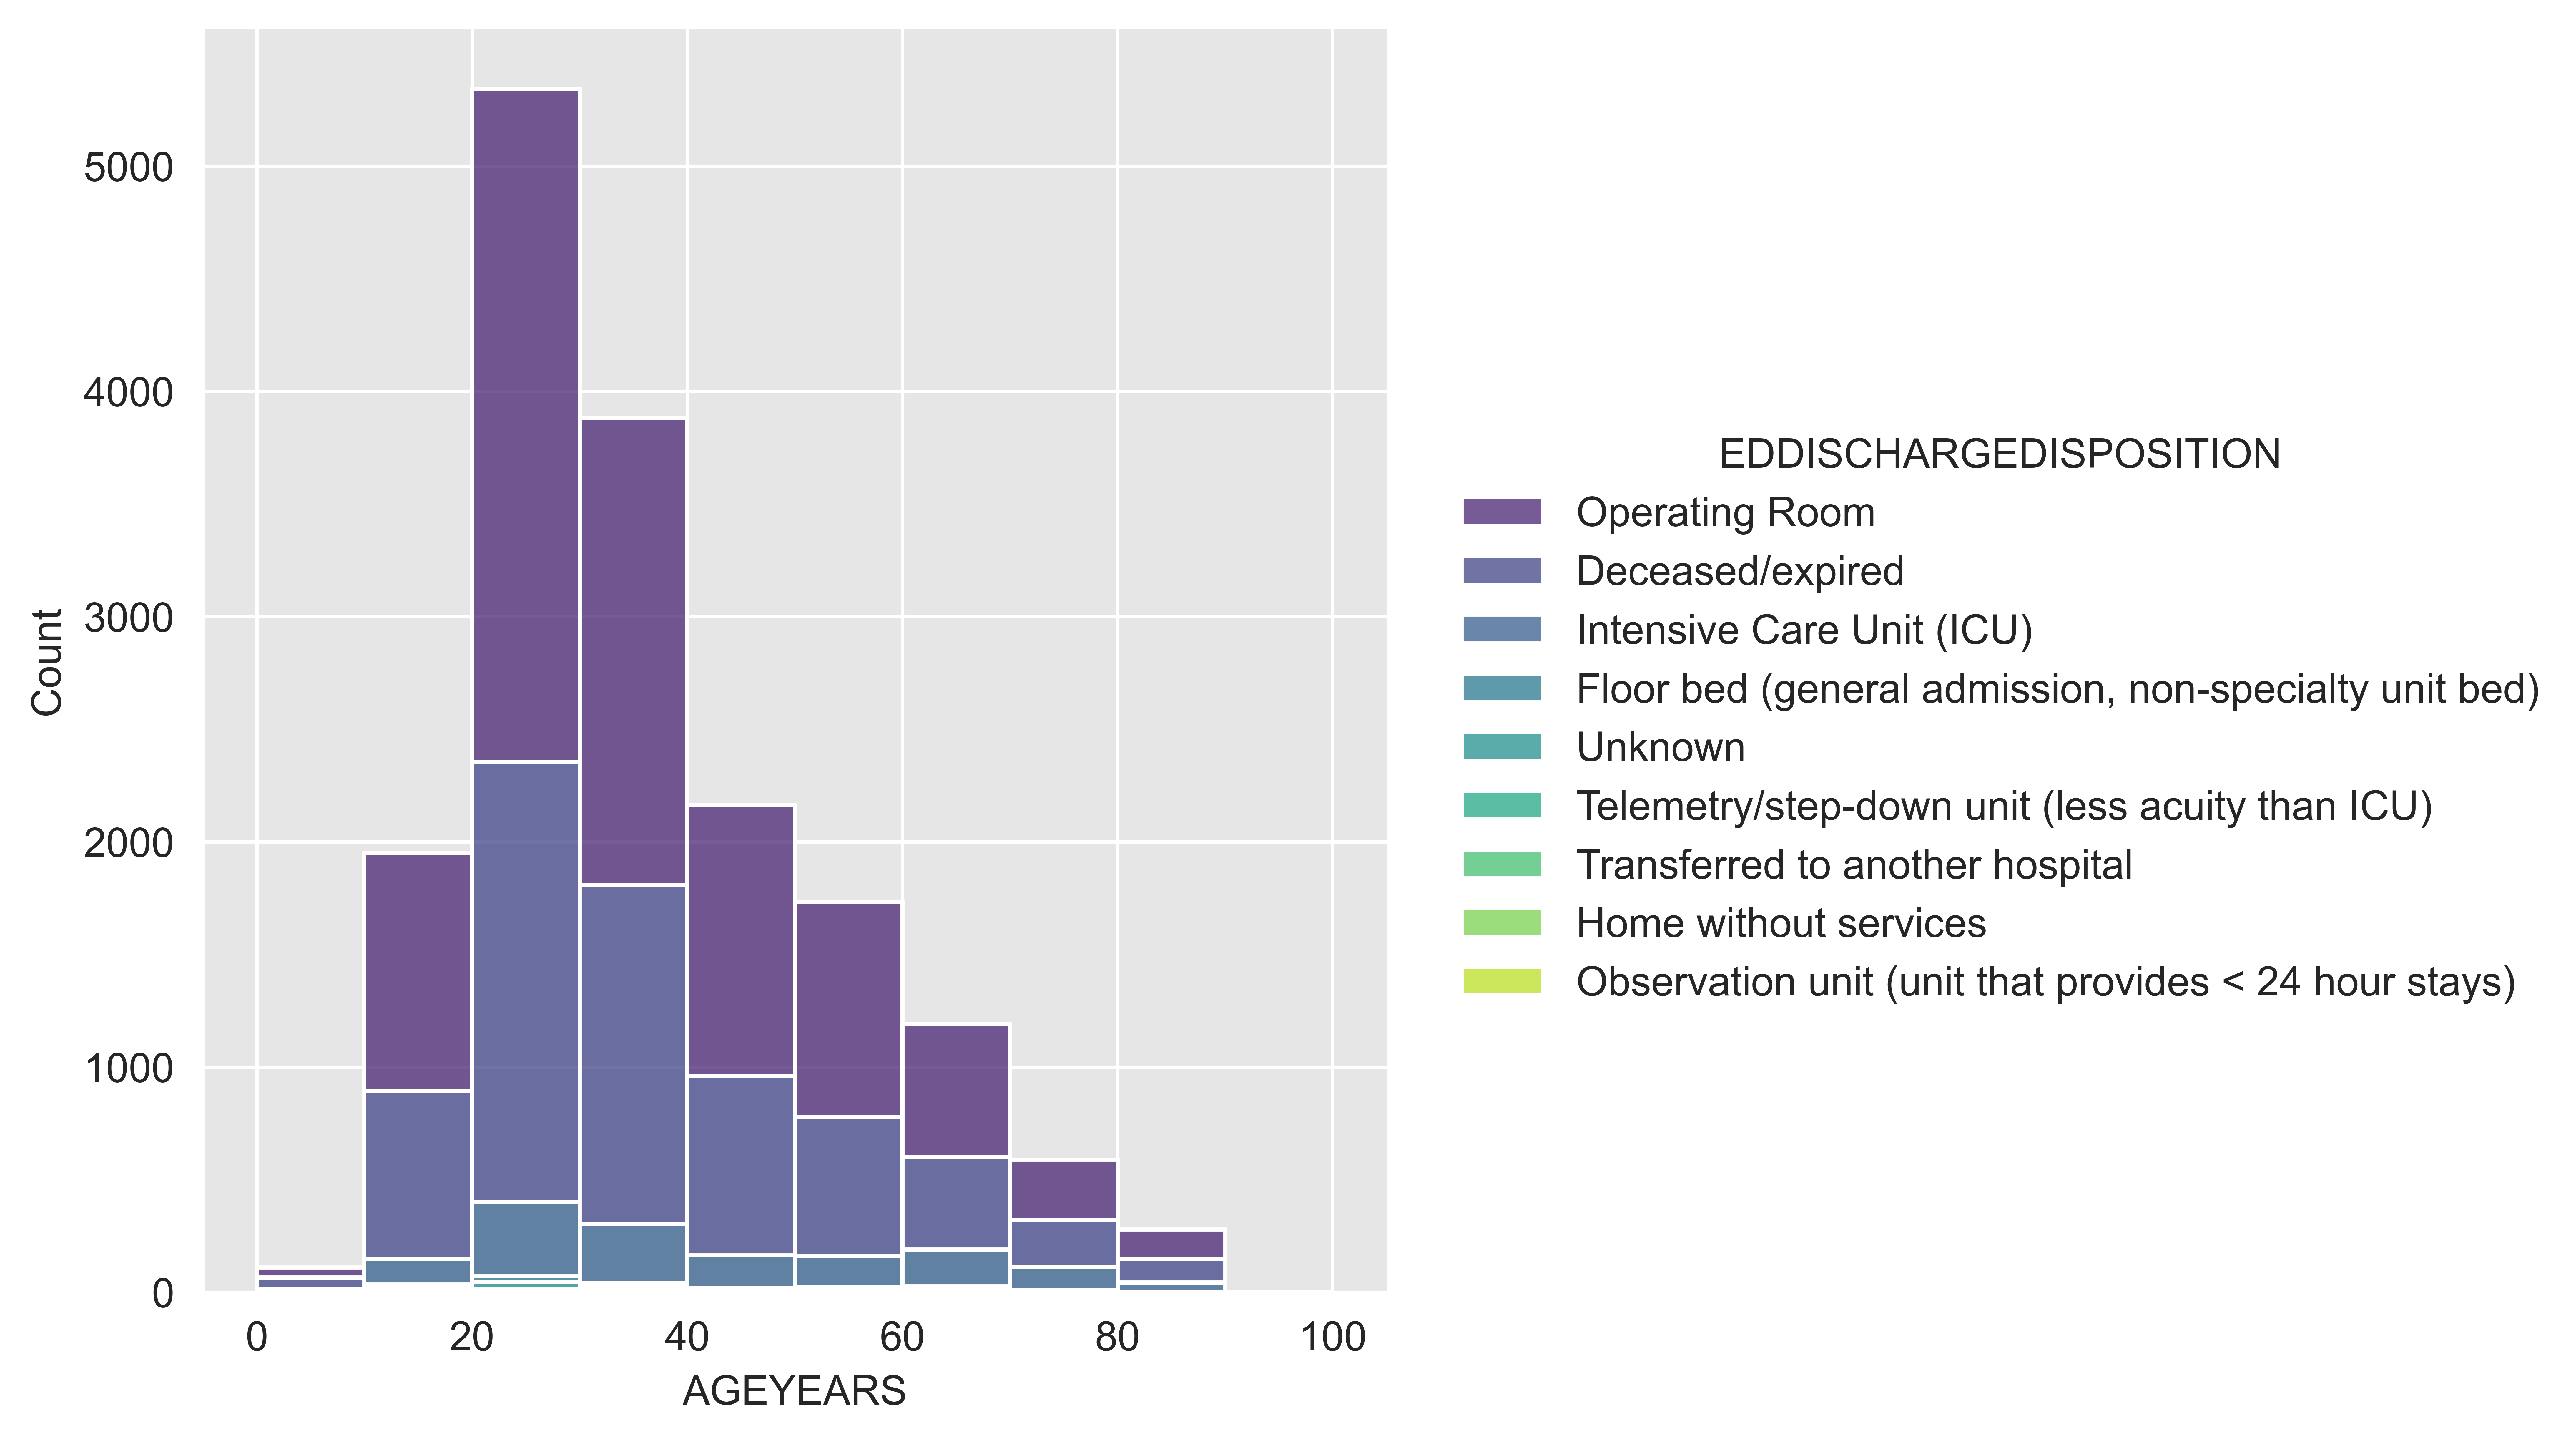

In [16]:
mpl.rcParams['figure.dpi'] = 1000
sns.set_style('darkgrid', {"axes.facecolor": ".9"})
sns.color_palette("viridis", as_cmap=True)

g = sns.displot(data=TRAUMA_all_df,
               x='AGEYEARS',
               hue='EDDISCHARGEDISPOSITION',
               stat='count',
               binwidth=10,
               binrange=(0,100),
               palette='viridis',
               multiple='stack')
plt.show()

In [17]:
mpl.rcParams['figure.dpi'] = 1000
sns.set_style('darkgrid', {"axes.facecolor": ".9"})
sns.color_palette("viridis", as_cmap=True)

g = sns.displot(data=TRAUMA_all_df,
               x='AGEYEARS',
               hue='HOSPDISCHARGEDISPOSITION',
               stat='count',
               binwidth=10,
               binrange=(0,100),
               palette='viridis',
               multiple='stack')
plt.show()

# Data about ICD Procedures (Includes **ALL** Procedures, not just the thoracomies but is only using thoracotomy patients)

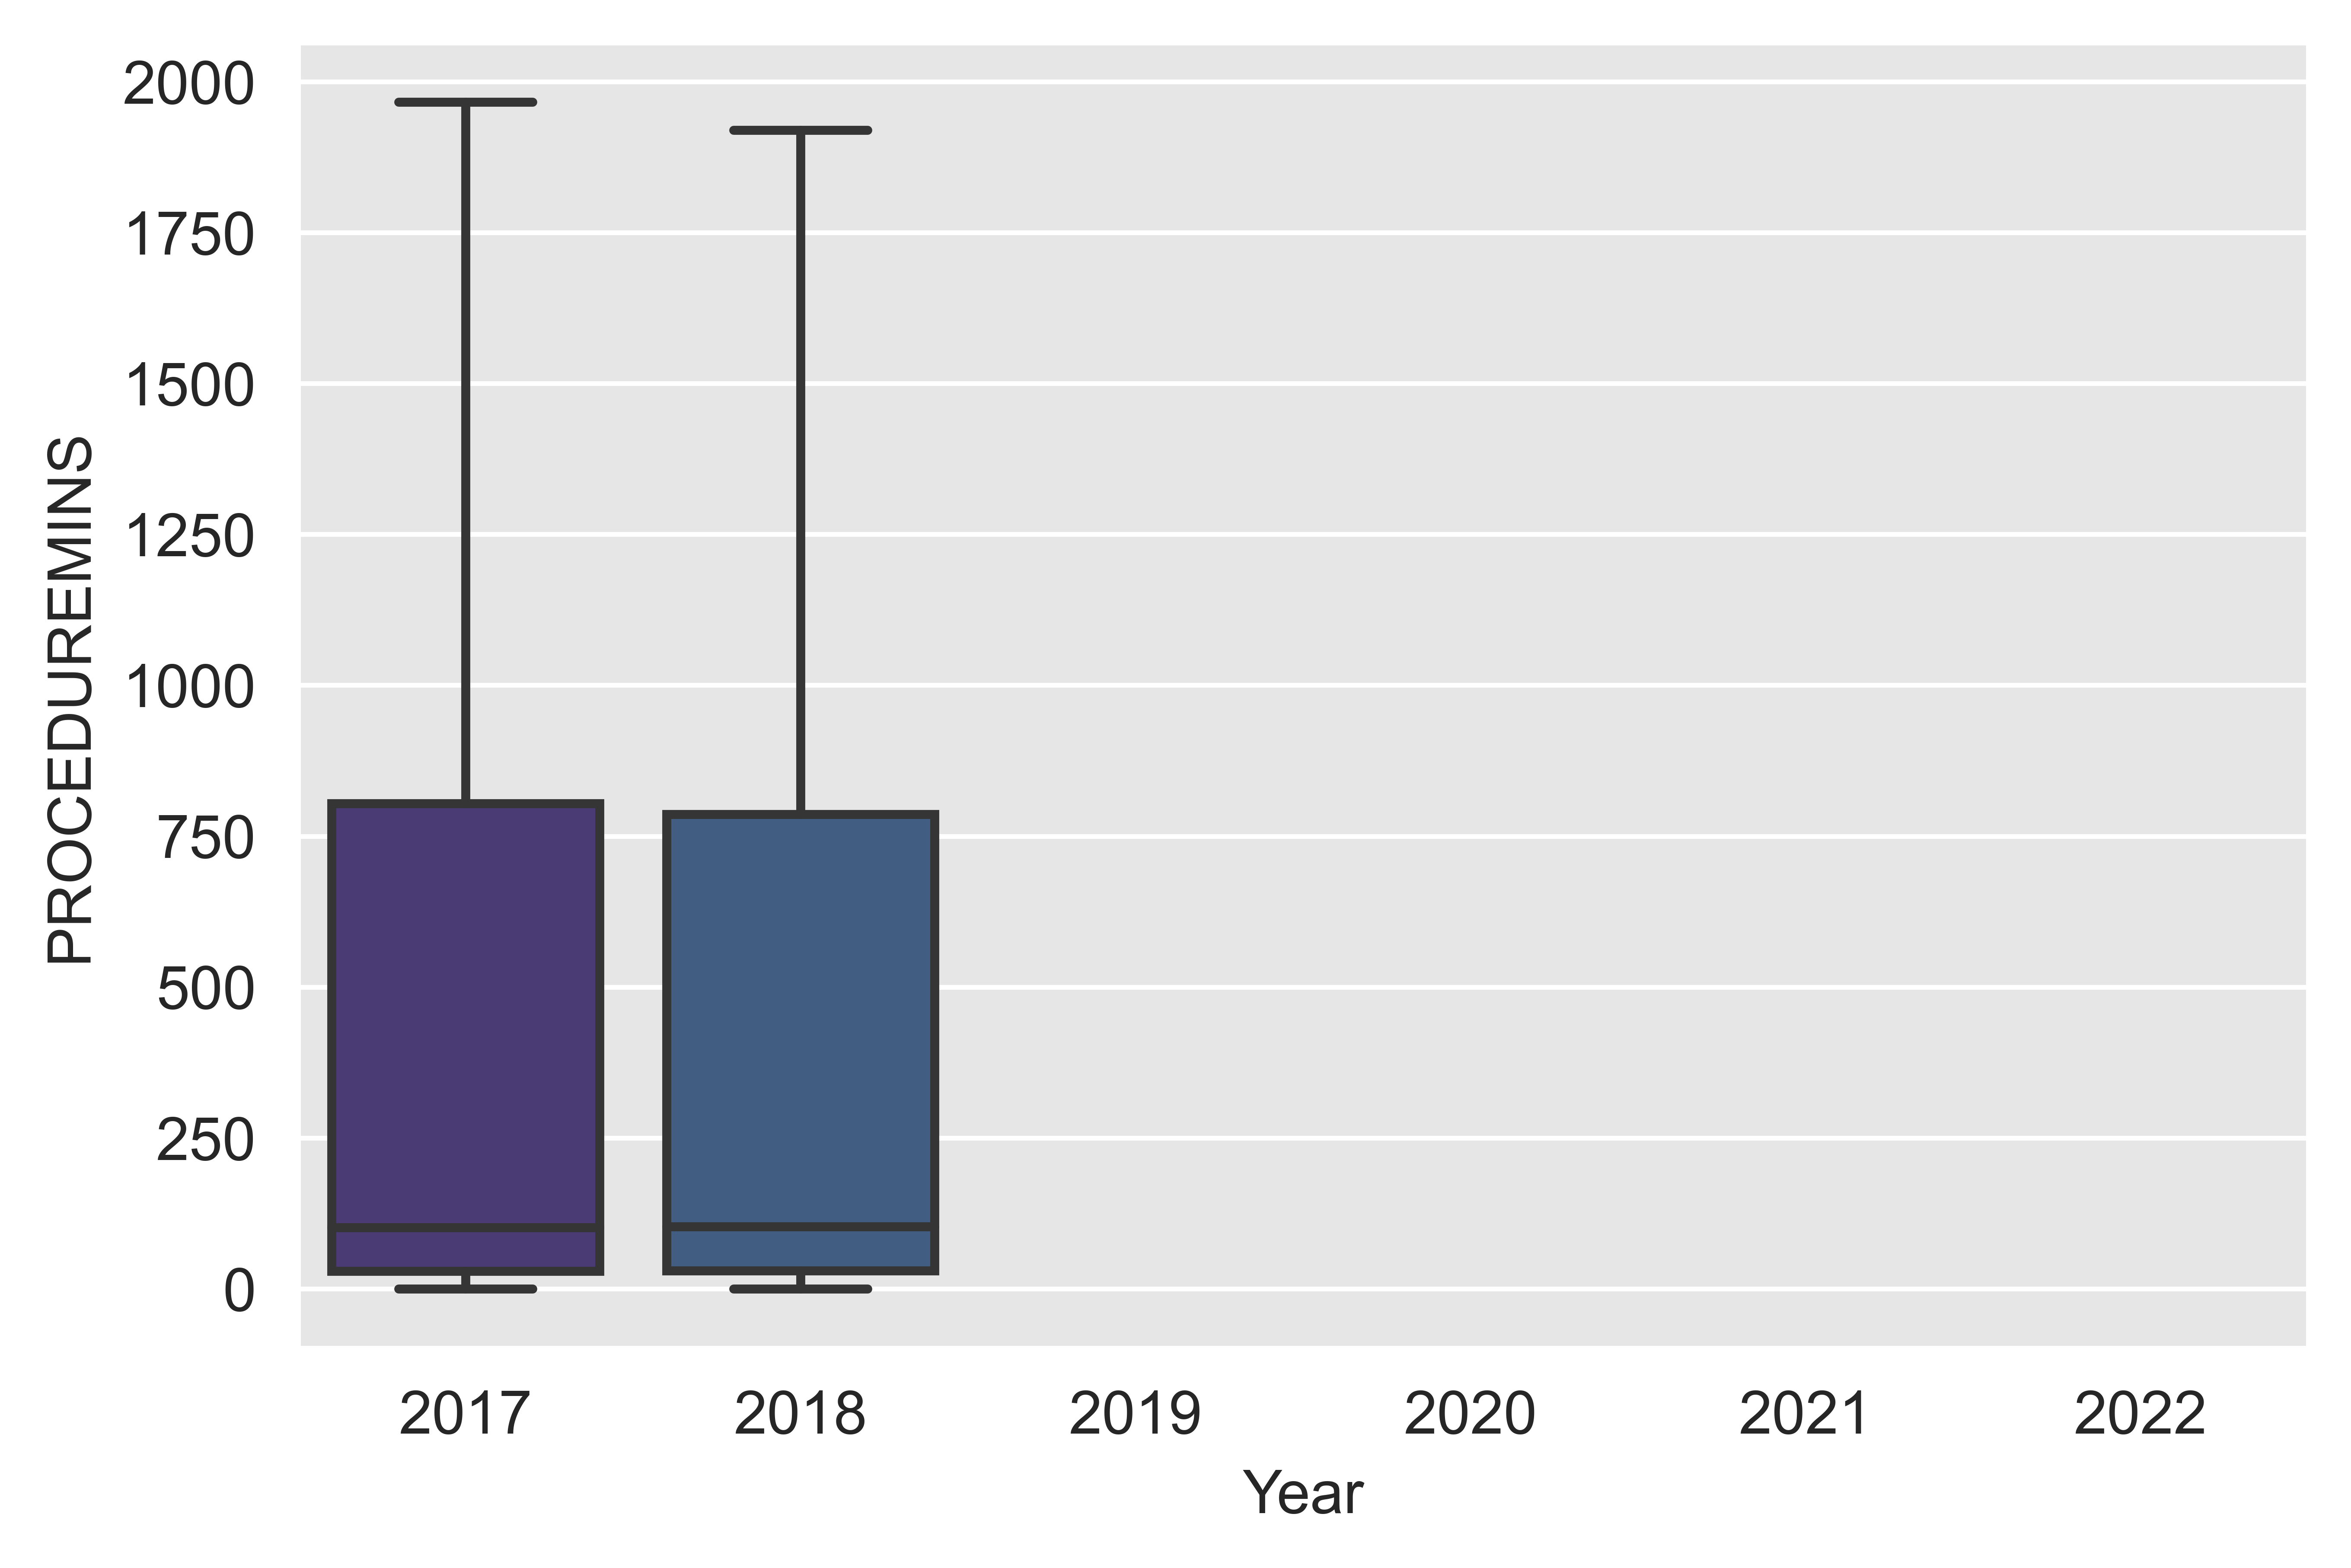

In [18]:
mpl.rcParams['figure.dpi'] = 1000
sns.set_style('darkgrid', {"axes.facecolor": ".9"})
sns.color_palette("viridis", as_cmap=True)

g = sns.boxplot(data=ICDPROCEDURE_all_df,
               y='PROCEDUREMINS',
               x='Year',
               showfliers=False,
               palette='viridis')
plt.show()

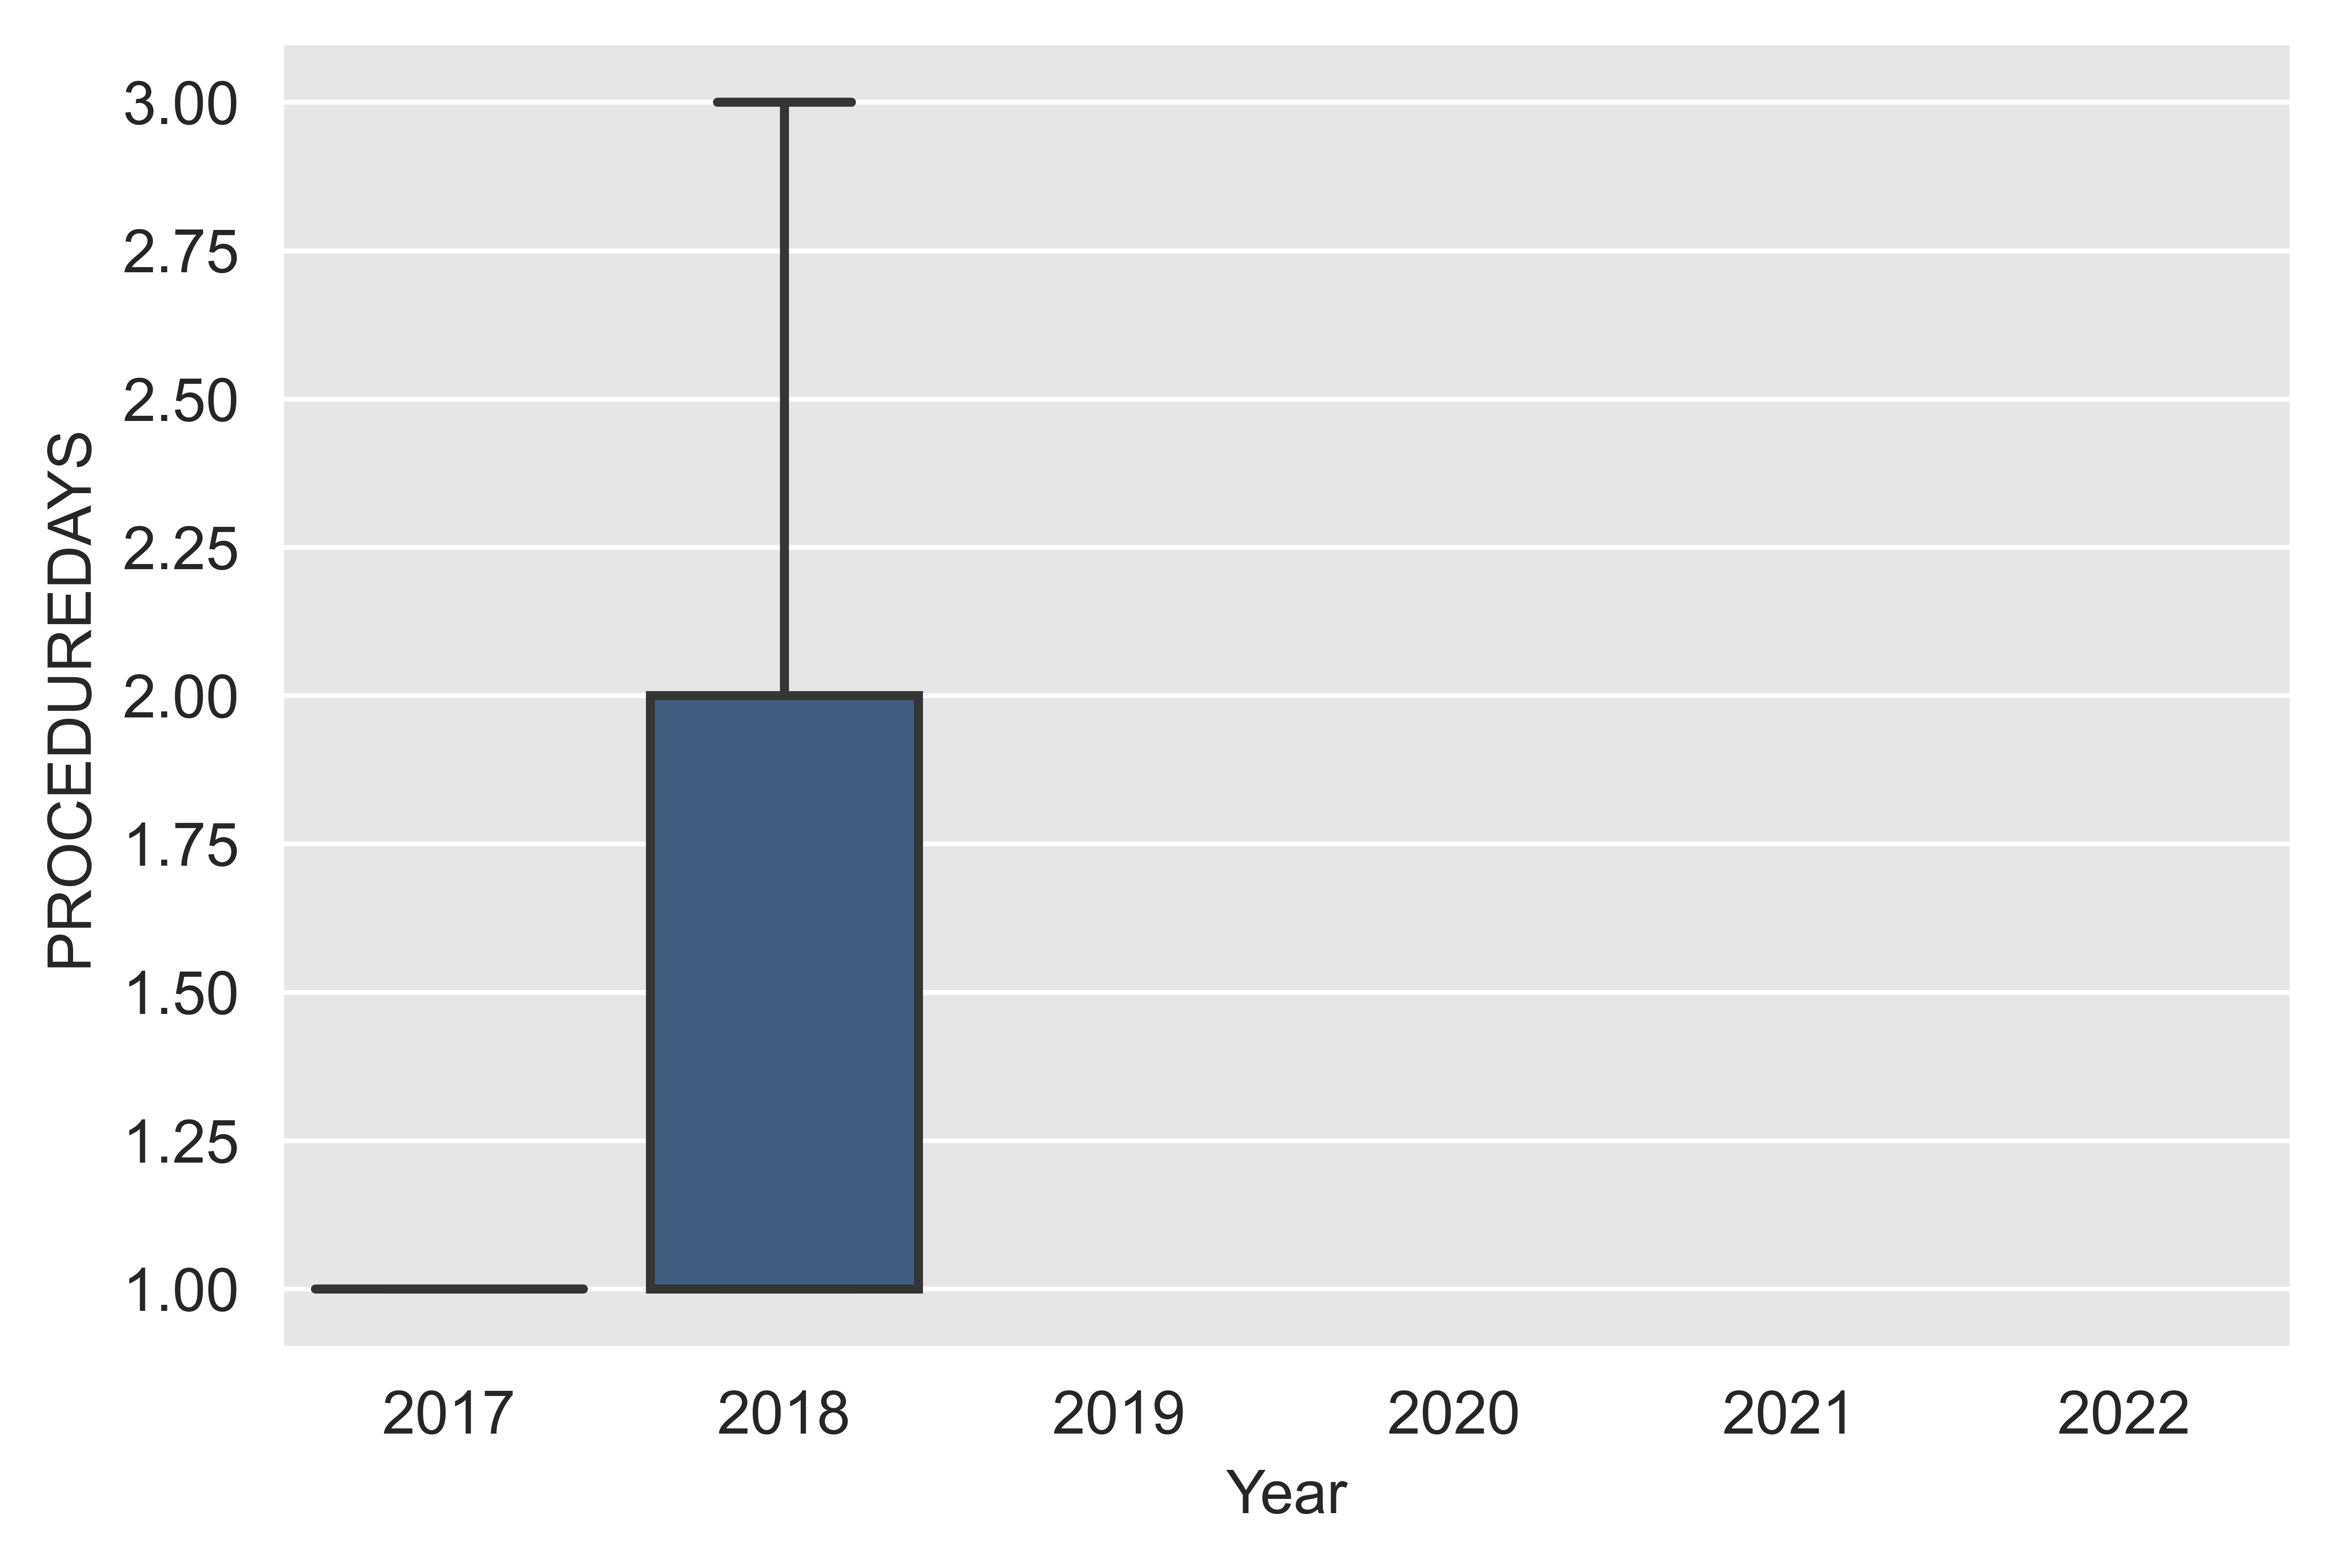

In [19]:
mpl.rcParams['figure.dpi'] = 1000
sns.set_style('darkgrid', {"axes.facecolor": ".9"})
sns.color_palette("viridis", as_cmap=True)

g = sns.boxplot(data=ICDPROCEDURE_all_df,
               y='PROCEDUREDAYS',
               x='Year',
               showfliers=False,
               palette='viridis')
plt.show()

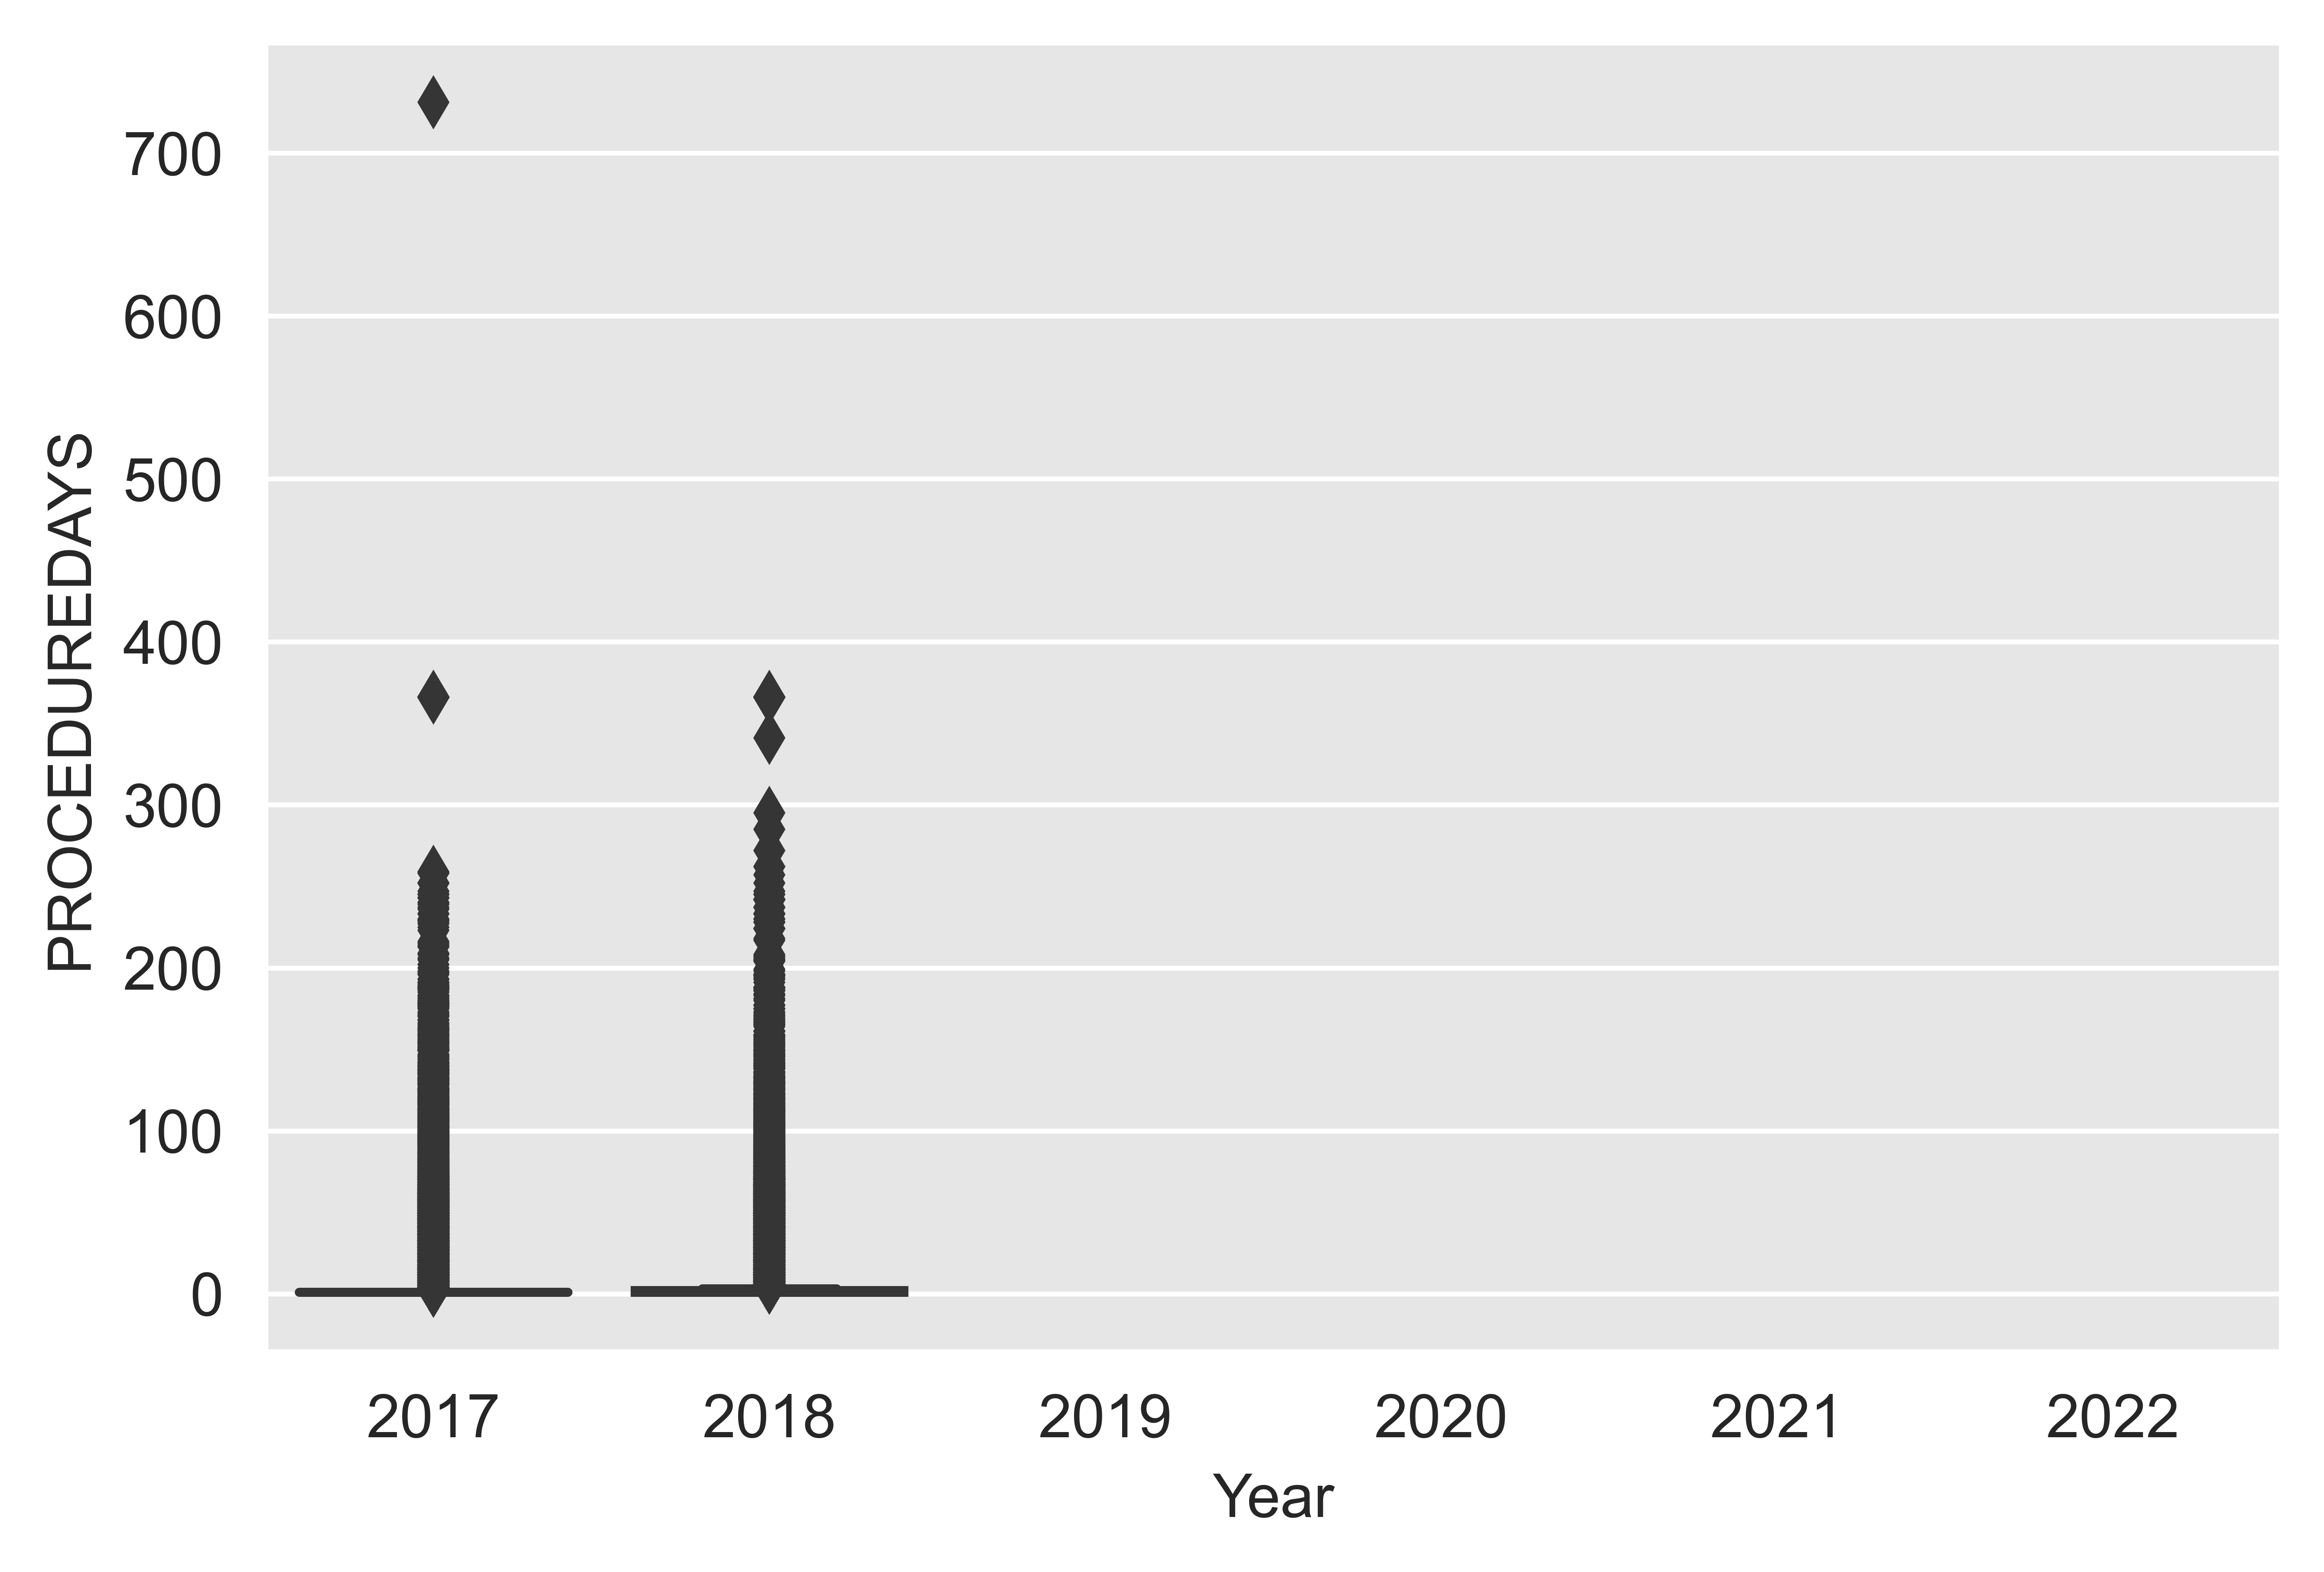

In [20]:
mpl.rcParams['figure.dpi'] = 1000
sns.set_style('darkgrid', {"axes.facecolor": ".9"})
sns.color_palette("viridis", as_cmap=True)

g = sns.boxplot(data=ICDPROCEDURE_all_df,
               y='PROCEDUREDAYS',
               x='Year',
               showfliers=True,
               palette='viridis')
plt.show()

In [21]:
thoracotomy_translated = pd.DataFrame(thoracotomy_codes, columns=['Codes'])
thoracotomy_translated = thoracotomy_translated['Codes'].replace(procedure_dict)
thoracotomy_timing = ICDPROCEDURE_all_df.loc[ICDPROCEDURE_all_df['ICDPROCEDURECODE'].isin(thoracotomy_translated)]
display(thoracotomy_timing.head())

mpl.rcParams['figure.dpi'] = 1000
sns.set_style('darkgrid', {"axes.facecolor": ".9"})
sns.color_palette("viridis", as_cmap=True)

g = sns.boxplot(data=thoracotomy_timing,
               y='PROCEDUREMINS',
               x='Year',
               showfliers=False,
               palette='viridis')
plt.show()

NameError: name 'procedure_dict' is not defined

In [ ]:
mpl.rcParams['figure.dpi'] = 1000
sns.set_style('darkgrid', {"axes.facecolor": ".9"})
sns.color_palette("viridis", as_cmap=True)

g = sns.boxplot(data=thoracotomy_timing,
               y='PROCEDUREDAYS',
               x='Year',
               showfliers=False,
               palette='viridis')
plt.show()

In [ ]:
mpl.rcParams['figure.dpi'] = 1000
sns.set_style('darkgrid', {"axes.facecolor": ".9"})
sns.color_palette("viridis", as_cmap=True)

g = sns.boxplot(data=thoracotomy_timing,
               y='PROCEDUREDAYS',
               x='Year',
               showfliers=True,
               palette='viridis')
plt.show()

# Create Mortality Statistics
## Create `DataFrame` of Mortality by `Year` and `Mechanism`

In [ ]:
mortality_year_table = pd.DataFrame(columns=['Year', 'Mortality %', 'MOI', 'Thoracotomies Performed (Year Total for All MOI)'])
years = range(2017, 2023) # set to year 2016 for max with this part of pipeline
for year in years:
    year_df = TRAUMA_all_df[TRAUMA_all_df['Year'] == year]
    penetrating_df = year_df[year_df['TRAUMATYPE'].isin(['Penetrating'])]
    expired_pen_df1 = penetrating_df[penetrating_df['EDDISCHARGEDISPOSITION'].isin(['Expired', 'Deceased/Expired', 'Deceased/expired'])]
    expired_pen_df2 = penetrating_df[penetrating_df['HOSPDISCHARGEDISPOSITION'].isin(['Expired', 'Deceased/Expired', 'Deceased/expired'])]
    mortality_pen_p = ((np.shape(expired_pen_df1)[0] + np.shape(expired_pen_df2)[0])/np.shape(penetrating_df)[0]) * 100
    blunt_df = year_df[year_df['TRAUMATYPE'].isin(['Blunt'])]
    expired_blunt_df1 = blunt_df[blunt_df['EDDISCHARGEDISPOSITION'].isin(['Expired', 'Deceased/Expired', 'Deceased/expired'])]
    expired_blunt_df2 = blunt_df[blunt_df['HOSPDISCHARGEDISPOSITION'].isin(['Expired', 'Deceased/Expired', 'Deceased/expired'])]
    mortality_blunt_p = ((np.shape(expired_blunt_df1)[0] + np.shape(expired_blunt_df2)[0])/np.shape(blunt_df)[0]) * 100
    final_pen_df = pd.DataFrame([[year, mortality_pen_p, 'Penetrating', np.shape(year_df)[0]]], columns=['Year', 'Mortality %', 'MOI', 'Thoracotomies Performed (Year Total for All MOI)'])
    final_blunt_df = pd.DataFrame([[year, mortality_blunt_p, 'Blunt', np.shape(year_df)[0]]], columns=['Year', 'Mortality %', 'MOI', 'Thoracotomies Performed (Year Total for All MOI)'])
    combined_df = pd.DataFrame(np.vstack((final_pen_df, final_blunt_df)), columns=['Year', 'Mortality %', 'MOI', 'Thoracotomies Performed (Year Total for All MOI)'])
    mortality_year_table = pd.concat([mortality_year_table, combined_df])
mortality_year_table['Mortality %'] = mortality_year_table['Mortality %'].astype(float)
mortality_year_table['Year'] = mortality_year_table['Year'].astype(int)
display(mortality_year_table)

## Plot Year vs. Mortality

In [ ]:
mpl.rcParams['figure.dpi'] = 1000
sns.set_style('darkgrid', {"axes.facecolor": ".9"})
sns.color_palette("viridis", as_cmap=True)

g = sns.lineplot(data=mortality_year_table,
               y='Mortality %',
               x='Year',
               hue='MOI',
               palette='viridis')
tick_labels = np.arange(mortality_year_table['Year'].min(), mortality_year_table['Year'].max() + 1)
g.set_xticks(tick_labels)
g.set_xticklabels(tick_labels.astype(int))
plt.show()

## Create `DataFrame` of Mortality by `Age` and `Trauma Type`

In [ ]:
mortality_age_table = pd.DataFrame(columns=['Mortality %', 'Trauma Type', 'Age Range', '# of Cases'])
age_ranges = range(0, 110, 10)

for age_range in age_ranges:
    age_range_df = TRAUMA_all_df[(TRAUMA_all_df['AGEYEARS'] > age_range+1) & (TRAUMA_all_df['AGEYEARS'] <= age_range+10)]
    penetrating_df = age_range_df[age_range_df['TRAUMATYPE'].isin(['Penetrating'])]
    if np.shape(penetrating_df)[0] == 0:
        continue
    expired_pen_df1 = penetrating_df[penetrating_df['EDDISCHARGEDISPOSITION'].isin(['Expired', 'Deceased/Expired', 'Deceased/expired'])]
    expired_pen_df2 = penetrating_df[penetrating_df['HOSPDISCHARGEDISPOSITION'].isin(['Expired', 'Deceased/Expired', 'Deceased/expired'])]
    mortality_pen_p = ((np.shape(expired_pen_df1)[0] + np.shape(expired_pen_df2)[0])/np.shape(penetrating_df)[0]) * 100
    blunt_df = age_range_df[age_range_df['TRAUMATYPE'].isin(['Blunt'])]
    if np.shape(blunt_df)[0] == 0:
        continue
    expired_blunt_df1 = blunt_df[blunt_df['EDDISCHARGEDISPOSITION'].isin(['Expired', 'Deceased/Expired', 'Deceased/expired'])]
    expired_blunt_df2 = blunt_df[blunt_df['HOSPDISCHARGEDISPOSITION'].isin(['Expired', 'Deceased/Expired', 'Deceased/expired'])]
    mortality_blunt_p = ((np.shape(expired_blunt_df1)[0] + np.shape(expired_blunt_df2)[0])/np.shape(blunt_df)[0]) * 100
    final_pen_df = pd.DataFrame([[mortality_pen_p, 'Penetrating']], columns=['Mortality %', 'Trauma Type'])
    final_blunt_df = pd.DataFrame([[mortality_blunt_p, 'Blunt']], columns=['Mortality %', 'Trauma Type'])
    final_pen_df['Age Range'] = '%i - %i'%(age_range+1, age_range+10)
    final_blunt_df['Age Range'] = '%i - %i'%(age_range+1, age_range+10)
    final_pen_df['# of Cases'] = np.shape(penetrating_df)[0]
    final_blunt_df['# of Cases'] = np.shape(blunt_df)[0]
    combined_df = pd.DataFrame(np.vstack((final_pen_df, final_blunt_df)), columns=['Mortality %', 'Trauma Type', 'Age Range', '# of Cases'])
    mortality_age_table = pd.concat([mortality_age_table, combined_df])
mortality_age_table['Mortality %'] = mortality_age_table['Mortality %'].astype(float)
mortality_age_table['Age Range'] = mortality_age_table['Age Range'].astype(str)
display(mortality_age_table)

## Plot Age vs. Mortality (`Barplot` & `Lineplot`)

In [ ]:
mpl.rcParams['figure.dpi'] = 1000
sns.set_style('darkgrid', {"axes.facecolor": ".9"})
sns.color_palette("viridis", as_cmap=True)

g = sns.barplot(data=mortality_age_table,
               y='Mortality %',
               x='Age Range',
               hue='Trauma Type',
               palette='viridis')
plt.show()

In [ ]:
mpl.rcParams['figure.dpi'] = 1000
sns.set_style('darkgrid', {"axes.facecolor": ".9"})
sns.color_palette("viridis", as_cmap=True)

g = sns.lineplot(data=mortality_age_table,
               y='Mortality %',
               x='Age Range',
               hue='Trauma Type',
               palette='viridis',
               marker='o')
plt.show()

## Create `DataFrame` of Mortality by `PROCEDUREMINS` and `Trauma Type`

In [ ]:
mortality_proctime_table = pd.DataFrame(columns=['Mortality %', 'Trauma Type', 'Procedure Time (Minutes after ED Arrival)', '# of Cases'])
proc_times = range(0,21, 1)

time_min_df = pd.DataFrame(columns=['INC_KEY', 'PROCEDUREMINS'])
for inc_key in np.unique(ICDPROCEDURE_all_df['INC_KEY']):
    inc_df = ICDPROCEDURE_all_df.loc[ICDPROCEDURE_all_df['INC_KEY'] == inc_key]
    first_proc_df = inc_df.loc[inc_df['PROCEDUREMINS'] == np.min(inc_df['PROCEDUREMINS'])]
    first_proc_min = np.min(first_proc_df['PROCEDUREMINS'])
    new_df = pd.DataFrame([[inc_key, first_proc_min]], columns=['INC_KEY', 'PROCEDUREMINS'])
    time_min_df = pd.concat([time_min_df, new_df])
    
    
for time in proc_times:
    trauma_time_df = TRAUMA_all_df.loc[TRAUMA_all_df['HMRRHGCTRLSURGMINS'] == time]
    penetrating_df = trauma_time_df[trauma_time_df['TRAUMATYPE'].isin(['Penetrating'])]
    if np.shape(penetrating_df)[0] == 0:
        continue
    expired_pen_df1 = penetrating_df[penetrating_df['EDDISCHARGEDISPOSITION'].isin(['Expired', 'Deceased/Expired', 'Deceased/expired'])]
    expired_pen_df2 = penetrating_df[penetrating_df['HOSPDISCHARGEDISPOSITION'].isin(['Expired', 'Deceased/Expired', 'Deceased/expired'])]
    mortality_pen_p = ((np.shape(expired_pen_df1)[0] + np.shape(expired_pen_df2)[0])/np.shape(penetrating_df)[0]) * 100
    blunt_df = trauma_time_df[trauma_time_df['TRAUMATYPE'].isin(['Blunt'])]
    if np.shape(blunt_df)[0] == 0:
        continue
    expired_blunt_df1 = blunt_df[blunt_df['EDDISCHARGEDISPOSITION'].isin(['Expired', 'Deceased/Expired', 'Deceased/expired'])]
    expired_blunt_df2 = blunt_df[blunt_df['HOSPDISCHARGEDISPOSITION'].isin(['Expired', 'Deceased/Expired', 'Deceased/expired'])]
    mortality_blunt_p = ((np.shape(expired_blunt_df1)[0] + np.shape(expired_blunt_df2)[0])/np.shape(blunt_df)[0]) * 100
    final_pen_df = pd.DataFrame([[mortality_pen_p, 'Penetrating']], columns=['Mortality %', 'Trauma Type'])
    final_blunt_df = pd.DataFrame([[mortality_blunt_p, 'Blunt']], columns=['Mortality %', 'Trauma Type'])
    final_pen_df['Procedure Time (Minutes after ED Arrival)'] = time
    final_blunt_df['Procedure Time (Minutes after ED Arrival)'] = time
    final_pen_df['# of Cases'] = np.shape(penetrating_df)[0]
    final_blunt_df['# of Cases'] = np.shape(blunt_df)[0]
    combined_df = pd.DataFrame(np.vstack((final_pen_df, final_blunt_df)), columns=['Mortality %', 'Trauma Type', 'Procedure Time (Minutes after ED Arrival)', '# of Cases'])
    mortality_proctime_table = pd.concat([mortality_proctime_table, combined_df])
mortality_proctime_table['Mortality %'] = mortality_proctime_table['Mortality %'].astype(float)
display(mortality_proctime_table)

In [ ]:
mpl.rcParams['figure.dpi'] = 1000
sns.set_style('darkgrid', {"axes.facecolor": ".9"})
sns.color_palette("viridis", as_cmap=True)

g = sns.lineplot(data=mortality_proctime_table,
               y='Mortality %',
               x='Procedure Time (Minutes after ED Arrival)',
               hue='Trauma Type',
               palette='viridis',
               marker='o')
plt.show()

## Create Mortality Table for `Mechanism` and `Age Range`

In [ ]:
mortality_mechanism_table = pd.DataFrame(columns=['Mortality %', 'Mechanism', 'Age Range', '# of Cases'])
age_ranges = range(0, 110, 10)
trauma_types = TRAUMA_all_df['MECHANISM'].unique()  # Get unique trauma types from your data

for age_range in age_ranges:
    for trauma_type in trauma_types:
        age_range_df = TRAUMA_all_df[(TRAUMA_all_df['AGEYEARS'] > age_range + 1) & (TRAUMA_all_df['AGEYEARS'] <= age_range + 10)]
        trauma_type_df = age_range_df[age_range_df['MECHANISM'] == trauma_type]
        
        if np.shape(trauma_type_df)[0] == 0:
            continue
        
        expired_df1 = trauma_type_df[trauma_type_df['EDDISCHARGEDISPOSITION'].isin(['Expired', 'Deceased/Expired', 'Deceased/expired'])]
        expired_df2 = trauma_type_df[trauma_type_df['HOSPDISCHARGEDISPOSITION'].isin(['Expired', 'Deceased/Expired', 'Deceased/expired'])]
        
        mortality_p = ((np.shape(expired_df1)[0] + np.shape(expired_df2)[0]) / np.shape(trauma_type_df)[0]) * 100
        
        final_df = pd.DataFrame([[mortality_p, trauma_type]], columns=['Mortality %', 'Mechanism'])
        final_df['Age Range'] = '%i - %i' % (age_range + 1, age_range + 10)
        final_df['# of Cases'] = np.shape(trauma_type_df)[0]
        
        combined_df = pd.DataFrame(final_df, columns=['Mortality %', 'Mechanism', 'Age Range', '# of Cases'])
        mortality_mechanism_table = pd.concat([mortality_mechanism_table, combined_df])

mortality_mechanism_table['Mortality %'] = mortality_mechanism_table['Mortality %'].astype(float)
mortality_mechanism_table['Age Range'] = mortality_mechanism_table['Age Range'].astype(str)
mortality_mechanism_table.reset_index(drop=True, inplace=True)

# Display the final mortality_age_table
display(mortality_mechanism_table.head())


In [ ]:
mpl.rcParams['figure.dpi'] = 1000
sns.set_style('darkgrid', {"axes.facecolor": ".9"})
sns.color_palette("viridis", as_cmap=True)

g = sns.lineplot(data=mortality_mechanism_table,
               y='Mortality %',
               x='Mechanism',
               palette='viridis', ci=None)
g.tick_params(axis='x', rotation=90, labelsize='xx-small')
plt.show()